# Homework 5: Transfer Learning with MobileNetV2 on the Intel Image Dataset

In this assignment you’ll take a modern pretrained CNN (MobileNetV2) and use it to classify the **Intel Image** dataset (6 scene classes). You’ll start with the network as a **frozen feature extractor**, then progressively **fine-tune** it in different ways. The goal is to understand *why* transfer learning works, how to design a good **classification head**, and how choices like **learning rate**, **learning-rate control (with Reduce on Plateau)**, and **which layers to unfreeze** affect accuracy.

### Learning Objectives

* Understand the difference between **feature extraction** (frozen backbone) and **fine-tuning** (unfrozen).
* How to design and compare **heads** on top of a pretrained backbone.
* Practical training knobs: **LR schedules** (fixed), **ReduceLROnPlateau**, **EarlyStopping**, **Dropout/L2**, and **BatchNorm** in heads.
* Fine-tuning strategies: unfreezing the **whole model**, the **top N layers**, or the **top K conv blocks**.


### Baseline model (starting point)

* `MobileNetV2(weights="imagenet", include_top=False, pooling="avg")`
  → backbone outputs a **1280-D** vector per image (already globally averaged).
* Minimal head: a **single Dense softmax** for 6 classes.
* **Do not** add another pooling layer when `pooling="avg"` is set.

### The five problems (high level)

For each of problems 1 - 4, you will perform 3 experiments, reflect on what you observed, and report the validation accuracy of your best model. 

1. **Problem 1 — Frozen backbone:** Redesign the **head** only (backbone stays frozen). Try ≥3 head variants and basic training knobs.
2. **Problem 2 — Unfreeze all:** Start from your best head and fine-tune the **entire** network with a **small LR**.
3. **Problem 3 — Unfreeze top N layers:** Keep most layers frozen; unfreeze only the **last N** and fine-tune.
4. **Problem 4 — Unfreeze top K blocks:** Unfreeze the **last K MobileNetV2 stages** (e.g., `block_16`, `Conv_1`, etc.) and fine-tune.
5. **Problem 5 — Final Reflection Question**

Use your HW4 CNN results as a reference point. Your aim is to **match or beat** that baseline with transfer learning, and to understand *why* your best choices worked.


## 1. Setup and Data Loading


In [4]:
# -------- Standard library --------
import os
import time
import random
from collections import Counter

# Quiet TensorFlow logs (set BEFORE importing TF)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# -------- Third-party --------
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import kagglehub

import tensorflow as tf
from tensorflow.keras import layers,models, callbacks, regularizers, initializers
from tensorflow.keras.callbacks import Callback,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    GlobalAveragePooling2D,
    GlobalMaxPooling2D,
    Input,
    MaxPooling2D,
    ReLU,
    SeparableConv2D,
)

from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.preprocessing.image import load_img, img_to_array



he = initializers.HeNormal()
l2reg = regularizers.l2(1e-4)

# Reproducibility settings
# -------------------------
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.keras.utils.set_random_seed(random_seed)

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))


/usr/local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Dataset Prototype Control (Important)

To speed up development and debugging, you will use a **balanced prototype version of the Intel training dataset** while building and testing your code.

* **During development:**
  Set `PROTO_TOTAL` to an integer (for example, `1400`) to train on a balanced subset of the training data
  (≈ 10% of the full Intel training set).

* **For your final runs:**
  Set `PROTO_TOTAL = None` (or `0`) to train on the **full training dataset**.

#### Notes

* This setting affects the **training pool** of images used to build `train_ds` and `val_ds`.
* The **validation fraction** (`VAL_FRAC`) is unchanged, but the **validation set will be smaller** when you use a prototype training pool.
* The **test set is unchanged** and is always evaluated on the full test dataset.

#### Before You Submit

Before submitting your notebook, make sure that:

* [ ] `PROTO_TOTAL` is set to `None` (or `0`) so the model is trained on the **full training dataset**
* [ ] Your notebook runs **top to bottom without errors**
* [ ] Training completes successfully using the full dataset

Submissions that leave `PROTO_TOTAL` set to a prototype value will **not** receive full credit.


In [5]:
# Prototype control:
#   - Set PROTO_TOTAL to an integer (e.g., 1400) to use a balanced subset (~10% of Intel train)
#   - Set PROTO_TOTAL to None (or 0) to use the full training set

PROTO_TOTAL = 1400   # <-- change to None for full dataset

### Utility function to plot learning curves and keep track of all results

- Call `print_results()` to see listing of all results logged so far

In [6]:

def plot_learning_curves(hist, title, verbose=True):
    
    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"Final Training Loss:            {hist.history['loss'][-1]:.4f}")
        print(f"Final Training Accuracy:        {hist.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Loss:          {hist.history['val_loss'][-1]:.4f}")
        print(f"Final Validation Accuracy:      {hist.history['val_accuracy'][-1]:.4f}")
        print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
        print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    results[title] = (val_acc_at_min_loss,min_val_epoch + 1)

results = {}

def print_results():
    for title, (acc, ep) in sorted(results.items(), 
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}\t{ep}")

###  Wrapper for training and testing

#### Assumptions:   
- Early stopping is default, add other callbacks as needed
- Training and testing sets already defined, accessed here as global variables

In [7]:
# Uses globals: train_ds, val_ds, test_ds

def train_and_test(model, 
                   epochs=500,
                   lr_schedule=1e-3,
                   optimizer="Adam",
                   title="Learning Curves",
                   batch_size=64,  # kept for API compatibility; ignored if datasets are batched
                   use_early_stopping=True,
                   patience=8,
                   min_delta=1e-4,
                   callbacks=None,
                   verbose=1,
                   return_history=False):

    print(f"\n{title}\n")

    # Choose optimizer
    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule)
    else:
        opt = optimizer  # assume already an optimizer instance

    # Compile
    model.compile(
        optimizer=opt,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    early_stop = EarlyStopping(
        monitor="val_loss",
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,
        verbose=verbose
    )

    extra_cbs = callbacks or []
    cbs = ([early_stop] if use_early_stopping else []) + extra_cbs

    start = time.time()

    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=val_ds,
        callbacks=cbs,
        verbose=verbose
    )

    # Best epoch consistent with EarlyStopping monitor
    best_epoch = int(np.argmin(history.history["val_loss"]))
    best_acc   = history.history["val_accuracy"][best_epoch]

    plot_learning_curves(history, title=title)

    test_loss, test_accuracy = model.evaluate(test_ds, verbose=0)

    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"\nValidation-Test Gap (accuracy): {abs(best_acc - test_accuracy):.6f}")

    end = time.time()
    print(f"\nExecution Time: " + format_hms(end - start))

    if return_history:
        return history


### Load the Intel Image Classification Dataset  



In [8]:
path      = kagglehub.dataset_download("puneet6060/intel-image-classification")
train_dir = os.path.join(path, "seg_train/seg_train")
test_dir  = os.path.join(path, "seg_test/seg_test")

In [9]:

AUTOTUNE = tf.data.AUTOTUNE

def list_files_and_labels(directory, class_names=None, exts=(".jpg", ".jpeg", ".png")):
    """
    Returns:
      filepaths: np.array[str]
      labels:    np.array[int32]
      class_names_used: list[str] in deterministic order
    """
    if class_names is None:
        class_names = sorted(
            d for d in os.listdir(directory)
            if os.path.isdir(os.path.join(directory, d))
        )
    else:
        # keep only classes that exist in this directory, preserve given order
        class_names = [c for c in class_names if os.path.isdir(os.path.join(directory, c))]

    class_to_idx = {name: idx for idx, name in enumerate(class_names)}

    filepaths = []
    labels = []

    for cname in class_names:
        folder = os.path.join(directory, cname)
        for fname in sorted(os.listdir(folder)):  # deterministic within class
            if fname.lower().endswith(exts):
                filepaths.append(os.path.join(folder, fname))
                labels.append(class_to_idx[cname])

    return np.array(filepaths), np.array(labels, dtype=np.int32), class_names


def stratified_split_indices(y, val_frac=0.2, seed=42):
    """
    Deterministic stratified split over indices.
    Returns: train_idx, val_idx (np arrays)
    """
    rng = np.random.default_rng(seed)
    y = np.asarray(y)

    train_idx_list = []
    val_idx_list = []

    classes = np.unique(y)
    for c in classes:
        idx = np.flatnonzero(y == c)
        rng.shuffle(idx)
        n_val = int(np.floor(len(idx) * val_frac))
        val_idx_list.append(idx[:n_val])
        train_idx_list.append(idx[n_val:])

    train_idx = np.concatenate(train_idx_list)
    val_idx   = np.concatenate(val_idx_list)

    # shuffle each split deterministically so batches mix classes
    rng.shuffle(train_idx)
    rng.shuffle(val_idx)

    return train_idx, val_idx


def balanced_subset_indices(y, total=None, per_class=None, seed=42, allow_smaller=True):
    """
    Choose a balanced subset of indices.

    Specify exactly one of:
      - total: desired total number of samples across all classes (realized = floor(total/k)*k)
      - per_class: desired samples per class

    Returns:
      subset_idx: np.array of indices into y
    """
    rng = np.random.default_rng(seed)
    y = np.asarray(y)
    classes = np.unique(y)
    k = len(classes)

    if (total is None) == (per_class is None):
        raise ValueError("Specify exactly one of total or per_class.")

    if per_class is None:
        per_class = int(total // k)  # balanced; realized total = per_class * k

    chosen = []
    for c in classes:
        idx = np.flatnonzero(y == c)
        rng.shuffle(idx)

        if len(idx) < per_class:
            if not allow_smaller:
                raise ValueError(f"Class {c} has only {len(idx)} items, need {per_class}.")
            take = len(idx)
        else:
            take = per_class

        chosen.append(idx[:take])

    subset_idx = np.concatenate(chosen)
    rng.shuffle(subset_idx)  # mix classes deterministically
    return subset_idx


def make_image_dataset(filepaths, labels, img_size=(150, 150), batch_size=32,
                       shuffle=False, seed=42, cache_to_disk=None):
    """
    Builds a tf.data.Dataset that loads images lazily from disk.
    - filepaths: np array of strings
    - labels:    np array of int32
    """
    ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))

    if shuffle:
        # shuffle file references (cheap), not image tensors
        ds = ds.shuffle(buffer_size=len(filepaths), seed=seed, reshuffle_each_iteration=True)

    def _load_and_preprocess(path, label):
        img_bytes = tf.io.read_file(path)
        img = tf.image.decode_image(img_bytes, channels=3, expand_animations=False)
        img = tf.image.resize(img, img_size, method="bilinear")
        img = tf.cast(img, tf.float32) / 255.0
        return img, label

    ds = ds.map(_load_and_preprocess, num_parallel_calls=AUTOTUNE)

    if cache_to_disk is not None:
        ds = ds.cache(cache_to_disk)

    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds


# -------------------------
# Intel dataset loading (with optional balanced prototype subset)
# -------------------------

IMG_SIZE    = (150, 150)
INPUT_SHAPE = IMG_SIZE + (3,)
BATCH_SIZE  = 32
VAL_FRAC    = 0.2
SEED        = random_seed  # use your existing seed

# 1) List train files/labels deterministically
train_files_all, train_labels_all, class_names = list_files_and_labels(train_dir)
num_classes = len(class_names)

# 2) Optional: take a balanced prototype subset (no images loaded yet)
if PROTO_TOTAL is not None and PROTO_TOTAL > 0:
    proto_idx = balanced_subset_indices(train_labels_all, total=PROTO_TOTAL, seed=SEED)
    train_files  = train_files_all[proto_idx]
    train_labels = train_labels_all[proto_idx]
else:
    train_files  = train_files_all
    train_labels = train_labels_all

# Report realized size (balanced)
per_class = len(train_files) // num_classes
print(f"Train pool: {len(train_files)} images ({per_class} per class), classes={num_classes}")

# 3) Stratified deterministic split of indices (still no images loaded)
train_idx, val_idx = stratified_split_indices(train_labels, val_frac=VAL_FRAC, seed=SEED)

# 4) Slice file lists for train/val
files_train = train_files[train_idx]
y_train     = train_labels[train_idx]
files_val   = train_files[val_idx]
y_val       = train_labels[val_idx]

print(f"Split sizes: train={len(files_train)}, val={len(files_val)} (VAL_FRAC={VAL_FRAC})")

# 5) Build datasets (lazy image loading)
train_ds = make_image_dataset(files_train, y_train, img_size=IMG_SIZE,
                              batch_size=BATCH_SIZE, shuffle=True, seed=SEED,
                              cache_to_disk=None)  # or "/tmp/train_cache"

val_ds   = make_image_dataset(files_val, y_val, img_size=IMG_SIZE,
                              batch_size=BATCH_SIZE, shuffle=False,
                              cache_to_disk=None)  # or "/tmp/val_cache"

# 6) Test set: keep same class mapping as train
test_files, test_labels, _ = list_files_and_labels(test_dir, class_names=class_names)

# Possible but not recommended: prototype the test set too (balanced). Set to None for full test.
PROTO_TEST_TOTAL = None
if PROTO_TEST_TOTAL is not None and PROTO_TEST_TOTAL > 0:
    test_idx = balanced_subset_indices(test_labels, total=PROTO_TEST_TOTAL, seed=SEED)
    test_files  = test_files[test_idx]
    test_labels = test_labels[test_idx]
    print(f"Test pool: {len(test_files)} images ({len(test_files)//num_classes} per class)")

test_ds = make_image_dataset(test_files, test_labels, img_size=IMG_SIZE,
                             batch_size=BATCH_SIZE, shuffle=False,
                             cache_to_disk=None)


Train pool: 1398 images (233 per class), classes=6
Split sizes: train=1122, val=276 (VAL_FRAC=0.2)


### Examine The Dataset

In [10]:

def show_counts_from_labels(name, labels, class_names):
    c = Counter(labels.tolist())
    counts = {class_names[k]: c.get(k, 0) for k in range(len(class_names))}
    print(f"{name} per-class counts:", counts)

print("class_names:", class_names)
print("train examples:", len(files_train), "val examples:", len(files_val), "test examples:", len(test_files))

show_counts_from_labels("train", y_train, class_names)
show_counts_from_labels("val",   y_val,   class_names)
show_counts_from_labels("test",  test_labels, class_names)


class_names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
train examples: 1122 val examples: 276 test examples: 3000
train per-class counts: {'buildings': 187, 'forest': 187, 'glacier': 187, 'mountain': 187, 'sea': 187, 'street': 187}
val per-class counts: {'buildings': 46, 'forest': 46, 'glacier': 46, 'mountain': 46, 'sea': 46, 'street': 46}
test per-class counts: {'buildings': 437, 'forest': 474, 'glacier': 553, 'mountain': 525, 'sea': 510, 'street': 501}


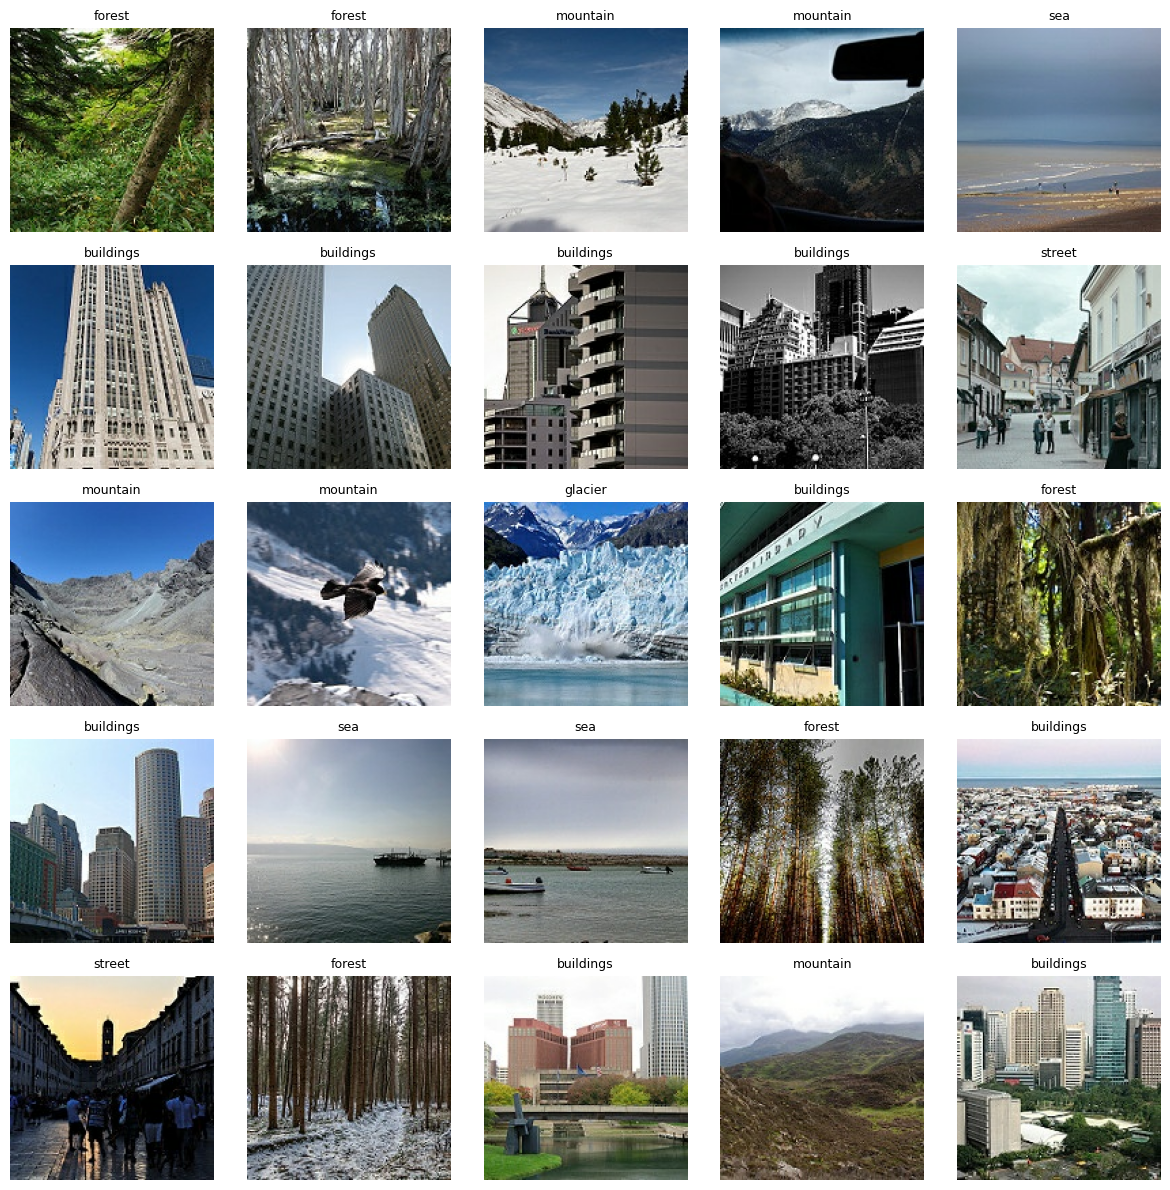

In [11]:
# Show 25 sample images

plt.figure(figsize=(12, 12))

# Take one batch from the dataset
images, labels = next(iter(train_ds))

for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(class_names[int(labels[i])], fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()


### Learning Rate Schedulers

In [12]:
# Must be input as callback in train_and_test(....   , callbacks=[reduce_lr] )

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.5,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=3,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=0,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-7,           # Lower bound on the learning rate.
    verbose=1,             # 0: quiet, 1: update messages.
)

### Prelude: Baseline Model

`MobileNetV2` is a lightweight, ImageNet-pretrained CNN that produces efficient, high-quality visual features.

See the **Appendix** for further information on `MobileNetV2`. 

The baseline model defined in the next cell is essentially a frozen **feature extractor** that outputs a 1280-D vector (after built-in **Global Average Pooling**).

> **NOTE:** MobileNetV2 ImageNet weights were trained at 224×224.
> We use 150×150 for faster training; this is valid because the backbone is fully convolutional
> when include_top=False (weights transfer to different input sizes).
>
> You may safely ignore the warning: "UserWarning: `input_shape` is undefined or non-square, ...."

In [13]:
# ALWAYS construct a new instance, to avoid sharing layers in multiple models

def make_base_model_pooled(trainable=False):
    base = mobilenet_v2.MobileNetV2(
        weights='imagenet', include_top=False,
        input_shape=INPUT_SHAPE, pooling='avg'
    )
    base.trainable = trainable
    return base
    
base = make_base_model_pooled()

print("Some statistics on the model:")
print("Total Keras layers:", len(base.layers))

# Count unique inverted-residual blocks by their prefix 'block_<n>'
block_ids = sorted({int(l.name.split('_')[1])
                    for l in base.layers if l.name.startswith('block_')})
print("Conv Block IDs:", block_ids, " (count:", len(block_ids), ")")

# Check if the final Conv_1 stage exists
has_conv1 = any(l.name.startswith('Conv_1') for l in base.layers)
print("Has Conv_1 stage:", has_conv1)
print('Model Output Shape:',base.output_shape)

/var/folders/qg/dqb2l_nd0x1g37_t0t22mwmw0000gn/T/ipykernel_1652/966669238.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = mobilenet_v2.MobileNetV2(


Some statistics on the model:
Total Keras layers: 155
Conv Block IDs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]  (count: 16 )
Has Conv_1 stage: True
Model Output Shape: (None, 1280)


In [14]:
# Ha, this is very long!

# base.summary()

/var/folders/qg/dqb2l_nd0x1g37_t0t22mwmw0000gn/T/ipykernel_1652/966669238.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = mobilenet_v2.MobileNetV2(



Model Baseline

Epoch 1/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 337ms/step - accuracy: 0.4716 - loss: 1.4617 - val_accuracy: 0.7935 - val_loss: 0.5939
Epoch 2/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 327ms/step - accuracy: 0.8431 - loss: 0.4390 - val_accuracy: 0.8478 - val_loss: 0.4115
Epoch 3/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 363ms/step - accuracy: 0.8800 - loss: 0.3127 - val_accuracy: 0.8732 - val_loss: 0.3823
Epoch 4/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 377ms/step - accuracy: 0.9102 - loss: 0.2489 - val_accuracy: 0.8442 - val_loss: 0.3569
Epoch 5/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 385ms/step - accuracy: 0.9419 - loss: 0.2121 - val_accuracy: 0.8442 - val_loss: 0.3557
Epoch 6/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 340ms/step - accuracy: 0.9421 - loss: 0.1834 - val_accuracy: 0.8551 - val_loss: 0.3637
Epoch 7/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 329ms/step - accuracy: 0.9495 - loss: 0.1604 - val_accuracy: 0.8623 - val_loss: 0.3497
Epoch 8/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 344ms/step - accuracy: 0.9607 

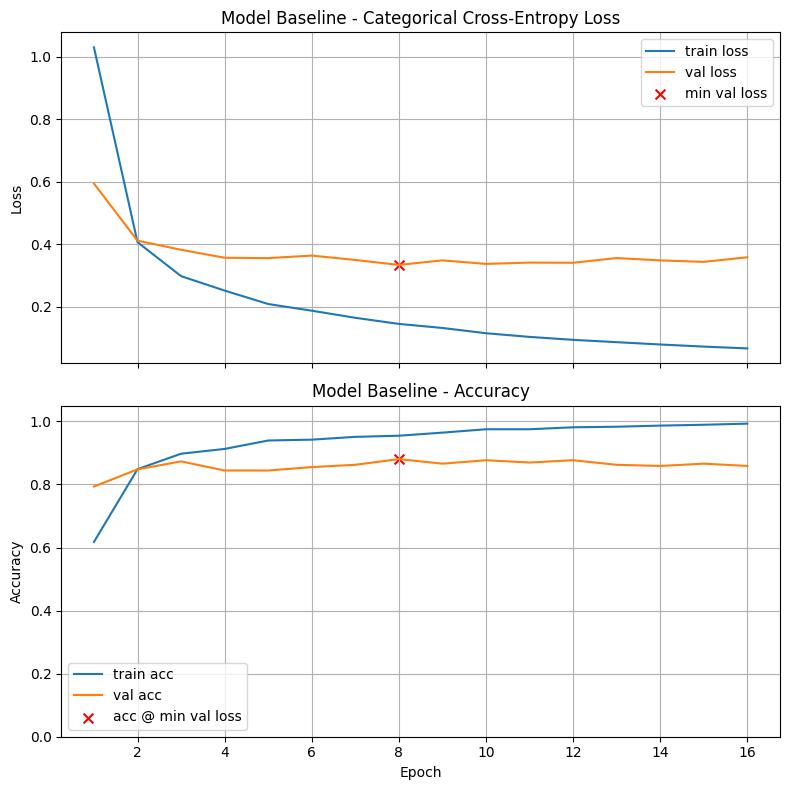

Final Training Loss:            0.0671
Final Training Accuracy:        0.9929
Final Validation Loss:          0.3584
Final Validation Accuracy:      0.8587
Minimum Validation Loss:        0.3339 (Epoch 8)
Validation Accuracy @ Min Loss: 0.8804

Test Loss: 0.3456
Test Accuracy: 0.8740

Validation-Test Gap (accuracy): 0.006435

Execution Time: 00:04:06


In [15]:
# ALWAYS construct a new instance, to avoid sharing layers in multiple models

base_model = make_base_model_pooled()

model_baseline = models.Sequential([
    base_model,
    Dense(num_classes, activation='softmax')  # use your Intel num_classes (6)
])

train_and_test(model_baseline, title="Model Baseline")

### Problem 1 — Frozen MobileNetV2 (Feature Extractor): Redesign the Head

**Goal.** Keep the MobileNetV2 backbone **frozen** and boost accuracy by modifying **only the classification head**.

**Setup.**

```python
base = make_base_pooled(trainable=False)  # MobileNetV2(include_top=False, pooling="avg")
```

This backbone already applies **Global Average Pooling** and outputs a **1280-D** feature vector per image.
Do **not** unfreeze any backbone layers and do **not** add another pooling layer.

### To Do:

1. **Ask an AI helper** (e.g., ChatGPT):
   *“What are some more complex heads that could improve this model on the Intel Image Classification Dataset, **without** unfreezing the backbone?”*
2. **Implement at least three** different head designs (they can be AI-suggested or inspired by HW4).
3. **Tune hyperparameters** for each experiment, such as:

   * **Learning-rate:** fixed LR
   * **EarlyStopping** settings
   * **Regularization:** Dropout and/or L2
   * **ReduceLROnPlateau:** on vs. off (may be combined with a fixed LR)
4. **Train and compare** the three heads.
5. **Answer the graded questions.**

### Notes / Constraints

* With `pooling="avg"`, the head receives a tensor of shape **(None, 1280)** → **do not** add `GlobalAveragePooling2D()` again.
* Using BatchNorm inside the head is fine; **do not** place BN immediately before the final softmax layer.


In [27]:
print("train_ds:", "train_ds" in globals())
print("val_ds:", "val_ds" in globals())
print("test_ds:", "test_ds" in globals())
print("INPUT_SHAPE:", "INPUT_SHAPE" in globals())
print("num_classes:", "num_classes" in globals())

# sanity-check one batch
images, labels = next(iter(train_ds))
print("batch images:", images.shape)
print("batch labels:", labels.shape)
print("num_classes:", num_classes)


train_ds: True
val_ds: True
test_ds: True
INPUT_SHAPE: True
num_classes: True
batch images: (32, 150, 150, 3)
batch labels: (32,)
num_classes: 6


/var/folders/qg/dqb2l_nd0x1g37_t0t22mwmw0000gn/T/ipykernel_1652/966669238.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = mobilenet_v2.MobileNetV2(



Model Baseline

Epoch 1/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 18s 406ms/step - accuracy: 0.4910 - loss: 1.3593 - val_accuracy: 0.8152 - val_loss: 0.4899
Epoch 2/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 339ms/step - accuracy: 0.8805 - loss: 0.3646 - val_accuracy: 0.8442 - val_loss: 0.4244
Epoch 3/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 366ms/step - accuracy: 0.9126 - loss: 0.2820 - val_accuracy: 0.8732 - val_loss: 0.3701
Epoch 4/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 416ms/step - accuracy: 0.9358 - loss: 0.2129 - val_accuracy: 0.8551 - val_loss: 0.3957
Epoch 5/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 413ms/step - accuracy: 0.9345 - loss: 0.2155 - val_accuracy: 0.8768 - val_loss: 0.3561
Epoch 6/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 403ms/step - accuracy: 0.9438 - loss: 0.1903 - val_accuracy: 0.8949 - val_loss: 0.3500
Epoch 7/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 365ms/step - accuracy: 0.9513 - loss: 0.1720 - val_accuracy: 0.8913 - val_loss: 0.3517
Epoch 8/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 385ms/step - accuracy: 0.9622 

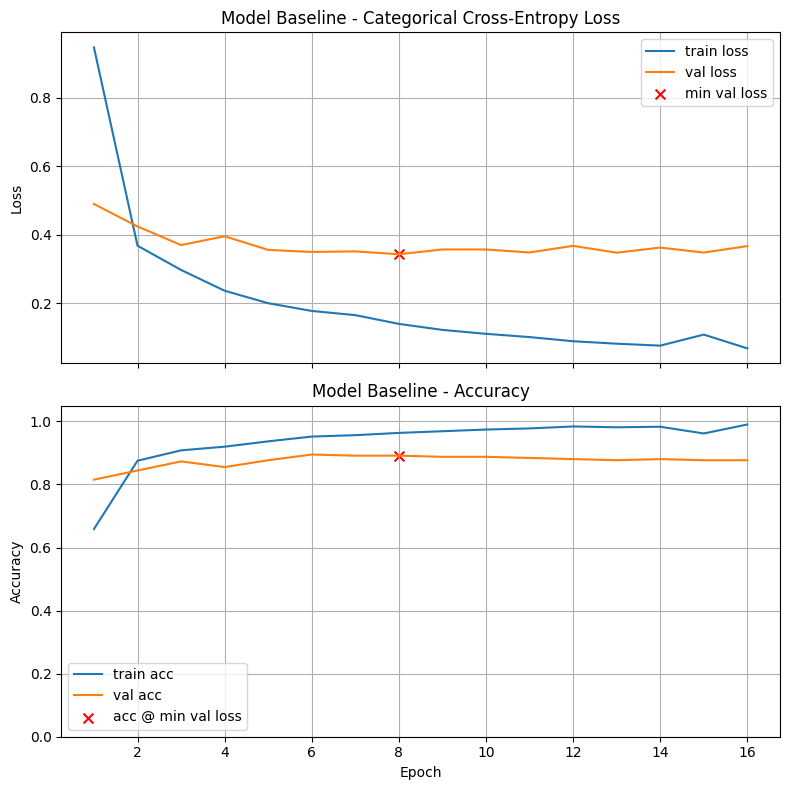

Final Training Loss:            0.0689
Final Training Accuracy:        0.9902
Final Validation Loss:          0.3671
Final Validation Accuracy:      0.8768
Minimum Validation Loss:        0.3433 (Epoch 8)
Validation Accuracy @ Min Loss: 0.8913

Test Loss: 0.3363
Test Accuracy: 0.8773

Validation-Test Gap (accuracy): 0.013971

Execution Time: 00:04:32


In [28]:
# ALWAYS construct a new instance, to avoid sharing layers in multiple models
base_model = make_base_model_pooled(trainable=False)

model_baseline = models.Sequential([
    base_model,
    Dense(num_classes, activation='softmax')
])

train_and_test(model_baseline, title="Model Baseline")


/var/folders/qg/dqb2l_nd0x1g37_t0t22mwmw0000gn/T/ipykernel_1652/966669238.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = mobilenet_v2.MobileNetV2(



Problem 1 — Head 1 — Dense(128)+Dropout(0.4), lr=1e-3

Epoch 1/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 438ms/step - accuracy: 0.4957 - loss: 1.3562 - val_accuracy: 0.8623 - val_loss: 0.4288
Epoch 2/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 400ms/step - accuracy: 0.8533 - loss: 0.4017 - val_accuracy: 0.8659 - val_loss: 0.4246
Epoch 3/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 404ms/step - accuracy: 0.9032 - loss: 0.3015 - val_accuracy: 0.8913 - val_loss: 0.3782
Epoch 4/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 414ms/step - accuracy: 0.9177 - loss: 0.2456 - val_accuracy: 0.8768 - val_loss: 0.3583
Epoch 5/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 363ms/step - accuracy: 0.9286 - loss: 0.1985 - val_accuracy: 0.8804 - val_loss: 0.3588
Epoch 6/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 418ms/step - accuracy: 0.9463 - loss: 0.1624 - val_accuracy: 0.8986 - val_loss: 0.3560
Epoch 7/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 405ms/step - accuracy: 0.9523 - loss: 0.1577 - val_accuracy: 0.8841 - val_loss: 0.3668
Epoch 8/200
36/36 ━━━━━━━━━━━━━━━━

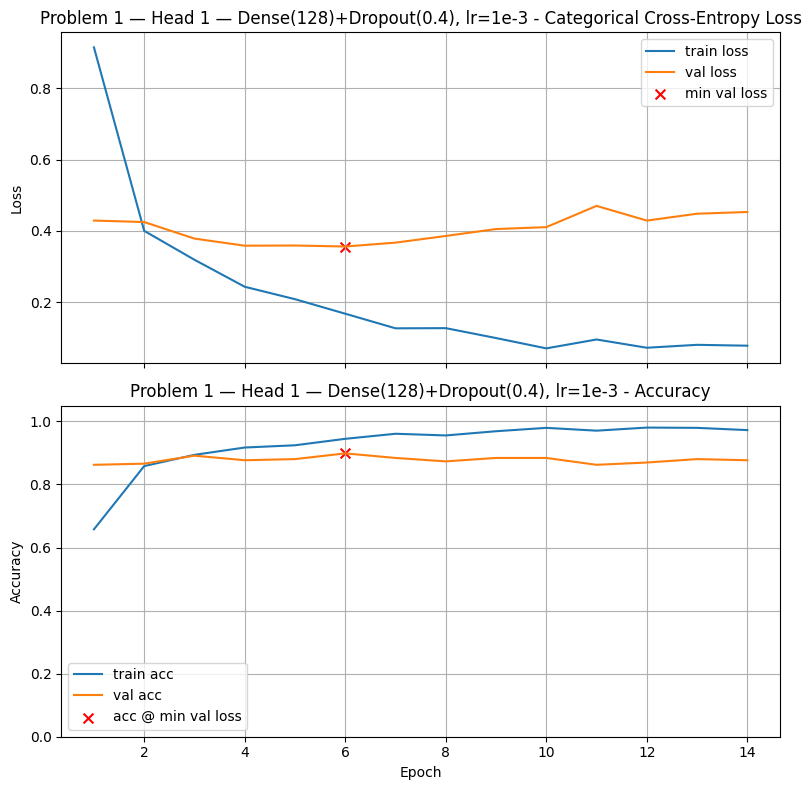

Final Training Loss:            0.0777
Final Training Accuracy:        0.9724
Final Validation Loss:          0.4528
Final Validation Accuracy:      0.8768
Minimum Validation Loss:        0.3560 (Epoch 6)
Validation Accuracy @ Min Loss: 0.8986

Test Loss: 0.3275
Test Accuracy: 0.8823

Validation-Test Gap (accuracy): 0.016217

Execution Time: 00:04:01

Problem 1 — Head 2 — 256BNDrop+128Drop, lr=1e-3

Epoch 1/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 427ms/step - accuracy: 0.5153 - loss: 1.4322 - val_accuracy: 0.7862 - val_loss: 0.5845
Epoch 2/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 362ms/step - accuracy: 0.8563 - loss: 0.4306 - val_accuracy: 0.8659 - val_loss: 0.4015
Epoch 3/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 351ms/step - accuracy: 0.8830 - loss: 0.3166 - val_accuracy: 0.8768 - val_loss: 0.3714
Epoch 4/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 358ms/step - accuracy: 0.8850 - loss: 0.3346 - val_accuracy: 0.8804 - val_loss: 0.3813
Epoch 5/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 375ms/step - accuracy: 0.9053 - lo

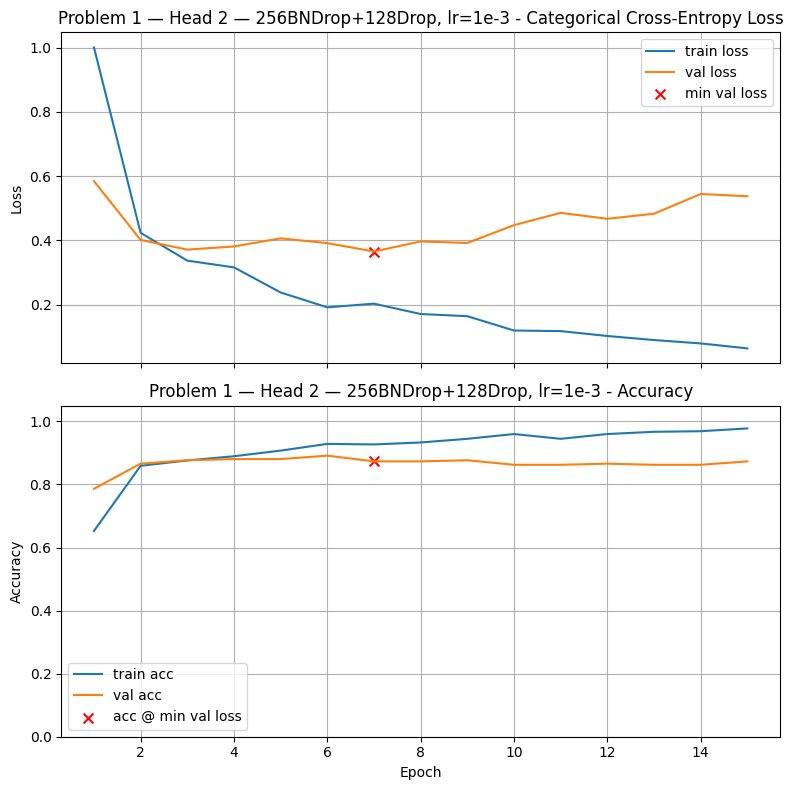

Final Training Loss:            0.0643
Final Training Accuracy:        0.9777
Final Validation Loss:          0.5374
Final Validation Accuracy:      0.8732
Minimum Validation Loss:        0.3655 (Epoch 7)
Validation Accuracy @ Min Loss: 0.8732

Test Loss: 0.3683
Test Accuracy: 0.8773

Validation-Test Gap (accuracy): 0.004145

Execution Time: 00:04:04

Problem 1 — Head 3 — Dense(256,L2=1e-4)+Drop(0.3), lr=5e-4 + ReduceLROnPlateau

Epoch 1/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 422ms/step - accuracy: 0.4963 - loss: 1.4636 - val_accuracy: 0.8297 - val_loss: 0.4585 - learning_rate: 5.0000e-04
Epoch 2/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 390ms/step - accuracy: 0.8543 - loss: 0.4172 - val_accuracy: 0.8514 - val_loss: 0.4082 - learning_rate: 5.0000e-04
Epoch 3/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 370ms/step - accuracy: 0.9212 - loss: 0.2732 - val_accuracy: 0.8696 - val_loss: 0.3974 - learning_rate: 5.0000e-04
Epoch 4/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 348ms/step - accuracy: 0.9196 - loss: 0.2554 - va

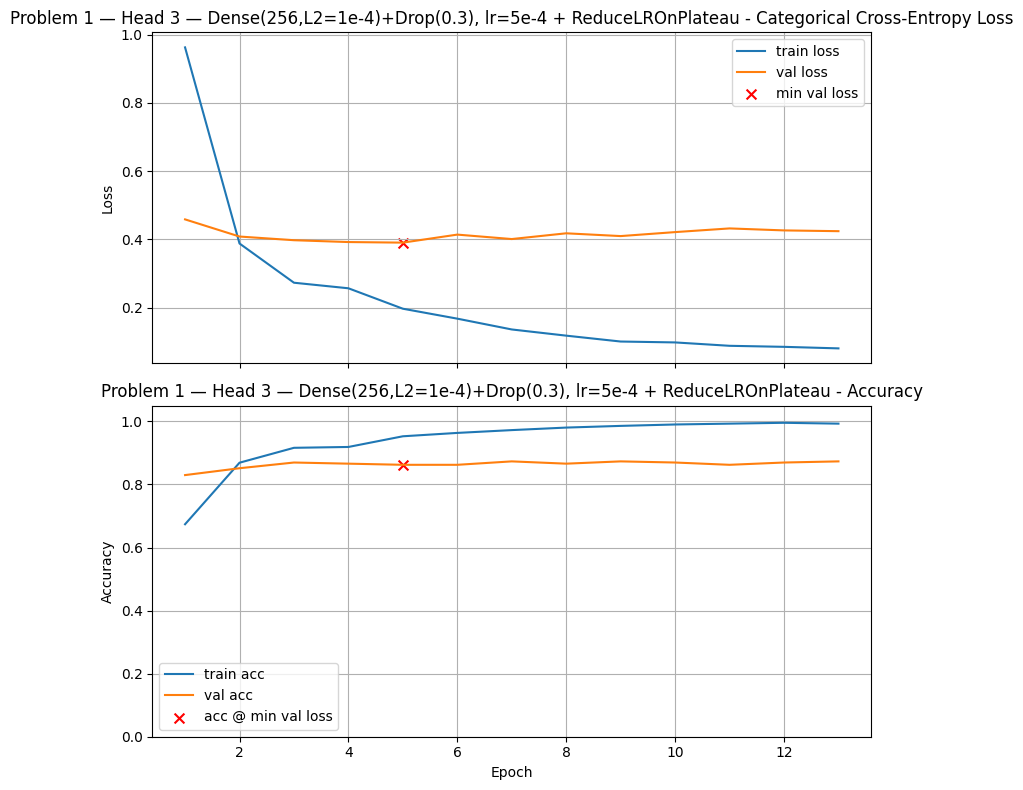

Final Training Loss:            0.0803
Final Training Accuracy:        0.9929
Final Validation Loss:          0.4239
Final Validation Accuracy:      0.8732
Minimum Validation Loss:        0.3903 (Epoch 5)
Validation Accuracy @ Min Loss: 0.8623

Test Loss: 0.3847
Test Accuracy: 0.8767

Validation-Test Gap (accuracy): 0.014348

Execution Time: 00:03:36


{'Head 1': 0.8985507488250732,
 'Head 2': 0.8731883764266968,
 'Head 3': 0.8623188138008118}

In [29]:
# =========================
# HW05 — Problem 1 (Frozen MobileNetV2): Redesign the Head
# Uses the notebook's provided:
#   - make_base_model_pooled(trainable=False)
#   - train_and_test(...)
#   - train_ds / val_ds / test_ds (used inside train_and_test)
#   - num_classes
# =========================

import numpy as np
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau

# (Optional) define ReduceLROnPlateau if you haven't run the earlier cell
if "reduce_lr" not in globals():
    reduce_lr = ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=3, min_delta=1e-4, cooldown=0, verbose=1
    )

def run_head_experiment(head_layers, *, lr=1e-3, use_reduce_lr=False, epochs=200, title=""):
    """
    Build a NEW frozen MobileNetV2 base, attach head_layers + softmax output, train, and return:
    (model, history, best_val_acc_at_min_val_loss)
    """
    base = make_base_model_pooled(trainable=False)  # IMPORTANT: new instance each time

    model = models.Sequential(
        [base] + head_layers + [Dense(num_classes, activation="softmax")]
    )

    cbs = [reduce_lr] if use_reduce_lr else None

    history = train_and_test(
        model,
        epochs=epochs,
        lr_schedule=lr,
        title=title,
        callbacks=cbs,
        return_history=True,
        verbose=1
    )

    best_epoch = int(np.argmin(history.history["val_loss"]))
    best_val_acc = float(history.history["val_accuracy"][best_epoch])
    return model, history, best_val_acc


# -------------------------
# Experiment 1: 1 hidden layer + dropout
# -------------------------
m1, h1, s1 = run_head_experiment(
    head_layers=[
        Dense(128, activation="relu"),
        Dropout(0.4),
    ],
    lr=1e-3,
    use_reduce_lr=False,
    epochs=200,
    title="Problem 1 — Head 1 — Dense(128)+Dropout(0.4), lr=1e-3"
)

# -------------------------
# Experiment 2: deeper head + batchnorm + dropout
# -------------------------
m2, h2, s2 = run_head_experiment(
    head_layers=[
        Dense(256, activation="relu"),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation="relu"),
        Dropout(0.3),
    ],
    lr=1e-3,
    use_reduce_lr=False,
    epochs=200,
    title="Problem 1 — Head 2 — 256BNDrop+128Drop, lr=1e-3"
)

# -------------------------
# Experiment 3: L2 regularization + lower LR + ReduceLROnPlateau
# -------------------------
m3, h3, s3 = run_head_experiment(
    head_layers=[
        Dense(256, activation="relu", kernel_regularizer=l2(1e-4)),
        Dropout(0.3),
    ],
    lr=5e-4,
    use_reduce_lr=True,
    epochs=200,
    title="Problem 1 — Head 3 — Dense(256,L2=1e-4)+Drop(0.3), lr=5e-4 + ReduceLROnPlateau"
)

scores = {
    "Head 1": s1,
    "Head 2": s2,
    "Head 3": s3,
}
scores


### Graded Questions

The reflection question is worth 5 points, and the validation accuracy question is worth 15 points. 

**Reflection Question:**

Which head architecture worked best for you, and what does that tell you about the role of head design and hyperparameters when the backbone is **frozen**?

**Instructions:**
 - Write a single paragraph (3–5 sentences).
 - Identify the head architecture and experiment that performed best.
 - Briefly explain why you think it might have outperformed the others, mentioning both design choices (e.g., dense layers, dropout) and hyperparameters (e.g., learning rate schedule, ReduceLROnPlateau).
 - Conclude with what this suggests about designing classification heads when the backbone is frozen.

**Your paragraph here (5pts):**

In my experiments, the best-performing classification head was Head 1 (a single Dense(128, relu) layer followed by Dropout(0.4)), which achieved the highest validation accuracy (≈0.899) at the epoch of minimum validation loss. This likely outperformed the deeper and more regularized heads because it added enough capacity to separate classes in the frozen backbone’s feature space without over-complicating the head, while dropout provided just enough regularization to prevent overfitting. With a straightforward optimizer setup (no aggressive scheduling), it also converged efficiently without destabilizing updates. Overall, this suggests that when the backbone is frozen, simple head designs with moderate capacity and well-chosen regularization often generalize best, and hyperparameter tuning should focus on the head rather than expecting feature learning from the backbone.

**Validation Accuracy here (15 pts):**

In [30]:
# Set a1 to the validation accuracy found by your best model for this problem. 
a1 = max(scores.values())
a1
         # Replace 0.0 with your answer

0.8985507488250732

In [31]:
# Graded Answer
# DO NOT change this cell in any way and do not make any other assignments to variable a1a in this problem         

print(f'a1 = {a1:.4f}') 


a1 = 0.8986


## Problem Two — Fine-tuning the Whole MobileNetV2 (Unfrozen)

**Goal.** Start from your best head from Problem 1, **unfreeze the backbone**, and fine-tune the entire model.

**Setup.** Build the base as **trainable** (it already applies Global Average Pooling and outputs a 1280-D vector—do not add another pooling layer):

```python
base = make_base_pooled(trainable=True)  # MobileNetV2(include_top=False, pooling="avg")
```

### To Do:

1. **Design at least three experiments** with the model **fully unfrozen**. Vary one or more of the following:

   * **Head choice** (select one from Problem 1).
   * **Learning-rate:** fixed LR
   * **EarlyStopping** parameters.
   * **Regularization:** Dropout and/or L2.
   * **ReduceLROnPlateau:** on vs. off (may be combined with a fixed LR).

2. **Run and compare** the three experiments **using the prototype training dataset**, focusing on:

   * training stability,
   * convergence behavior,
   * and validation performance trends.

   Use these runs to **narrow down reasonable configurations**, not to identify a single “optimal” setting.

3. **Select one configuration** and **retrain it on the full training dataset**, then use this run when answering the graded questions.

### Notes

* When fine-tuning a fully unfrozen pretrained model, it is common to use a **much smaller learning rate** (e.g., $1\times10^{-5}$ to $3\times10^{-5}$).
* Small changes in relative performance between the prototype and full dataset are expected. 


/var/folders/qg/dqb2l_nd0x1g37_t0t22mwmw0000gn/T/ipykernel_1652/966669238.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = mobilenet_v2.MobileNetV2(



P2 PROTO — Exp1 — lr=1e-5, drop=0.4, no ReduceLROnPlateau

Epoch 1/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.1968 - loss: 2.2828 - val_accuracy: 0.3043 - val_loss: 1.9106
Epoch 2/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.2805 - loss: 1.9016 - val_accuracy: 0.4348 - val_loss: 1.6376
Epoch 3/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.3657 - loss: 1.6082 - val_accuracy: 0.5000 - val_loss: 1.4330
Epoch 4/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.4791 - loss: 1.3979 - val_accuracy: 0.5362 - val_loss: 1.2714
Epoch 5/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.5323 - loss: 1.2847 - val_accuracy: 0.6087 - val_loss: 1.1480
Epoch 6/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.6171 - loss: 1.1002 - val_accuracy: 0.6377 - val_loss: 1.0434
Epoch 7/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.6711 - loss: 0.9858 - val_accuracy: 0.6703 - val_loss: 0.9546
Epoch 8/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step 

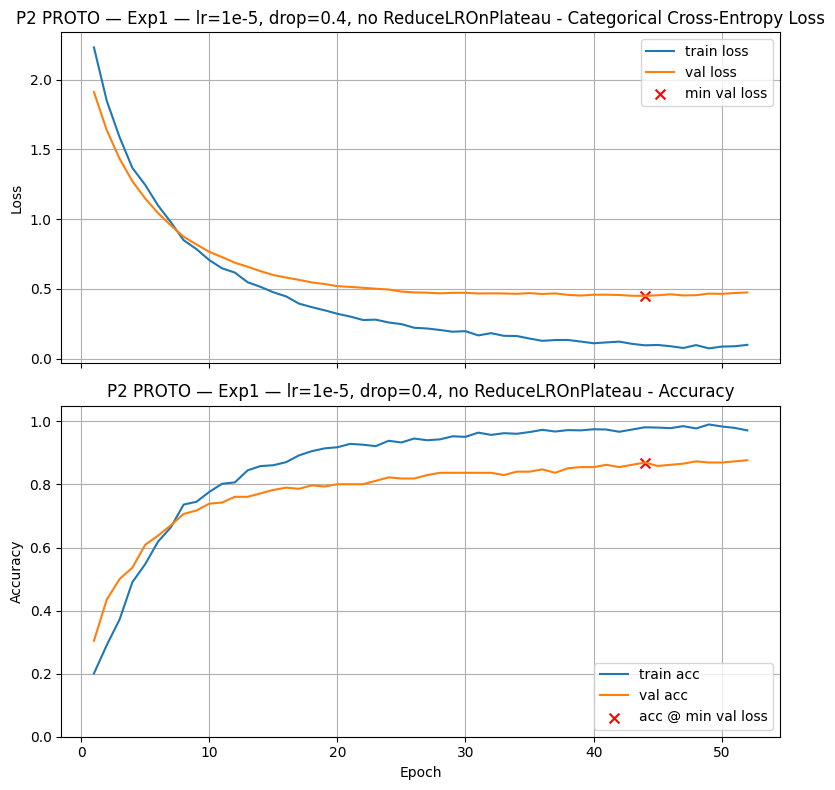

Final Training Loss:            0.0980
Final Training Accuracy:        0.9715
Final Validation Loss:          0.4738
Final Validation Accuracy:      0.8768
Minimum Validation Loss:        0.4493 (Epoch 44)
Validation Accuracy @ Min Loss: 0.8696

Test Loss: 0.3904
Test Accuracy: 0.8663

Validation-Test Gap (accuracy): 0.003232

Execution Time: 00:53:17
[P2 PROTO — Exp1 — lr=1e-5, drop=0.4, no ReduceLROnPlateau] best_epoch=43, best_val_acc=0.869565

P2 PROTO — Exp2 — lr=2e-5, drop=0.3, +ReduceLROnPlateau

Epoch 1/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.2512 - loss: 1.9640 - val_accuracy: 0.4493 - val_loss: 1.5437 - learning_rate: 2.0000e-05
Epoch 2/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.5005 - loss: 1.3610 - val_accuracy: 0.5652 - val_loss: 1.1947 - learning_rate: 2.0000e-05
Epoch 3/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.6385 - loss: 1.0361 - val_accuracy: 0.6739 - val_loss: 0.9692 - learning_rate: 2.0000e-05
Epoch 4/200
36/36 ━━━━━━━━

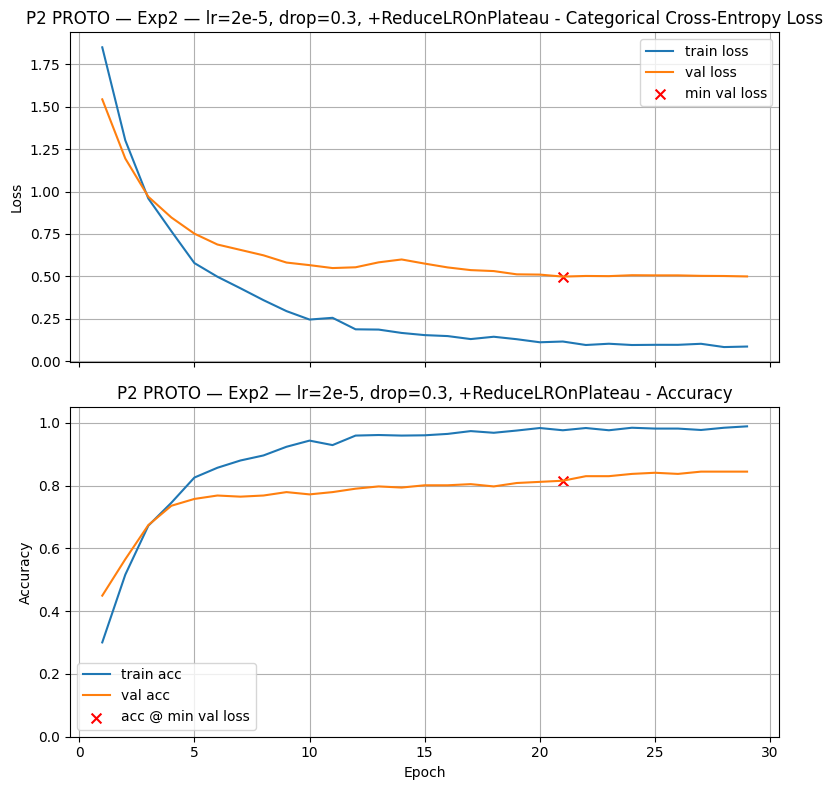

Final Training Loss:            0.0854
Final Training Accuracy:        0.9884
Final Validation Loss:          0.4990
Final Validation Accuracy:      0.8442
Minimum Validation Loss:        0.4980 (Epoch 21)
Validation Accuracy @ Min Loss: 0.8152

Test Loss: 0.4495
Test Accuracy: 0.8440

Validation-Test Gap (accuracy): 0.028783

Execution Time: 00:29:05
[P2 PROTO — Exp2 — lr=2e-5, drop=0.3, +ReduceLROnPlateau] best_epoch=20, best_val_acc=0.815217

P2 PROTO — Exp3 — lr=1e-5, drop=0.3, L2=1e-4, +ReduceLROnPlateau

Epoch 1/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.1439 - loss: 2.3269 - val_accuracy: 0.1341 - val_loss: 2.1491 - learning_rate: 1.0000e-05
Epoch 2/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.2611 - loss: 1.8458 - val_accuracy: 0.2645 - val_loss: 1.8105 - learning_rate: 1.0000e-05
Epoch 3/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.3712 - loss: 1.5793 - val_accuracy: 0.3732 - val_loss: 1.5540 - learning_rate: 1.0000e-05
Epoch 4/200
36/36 ━

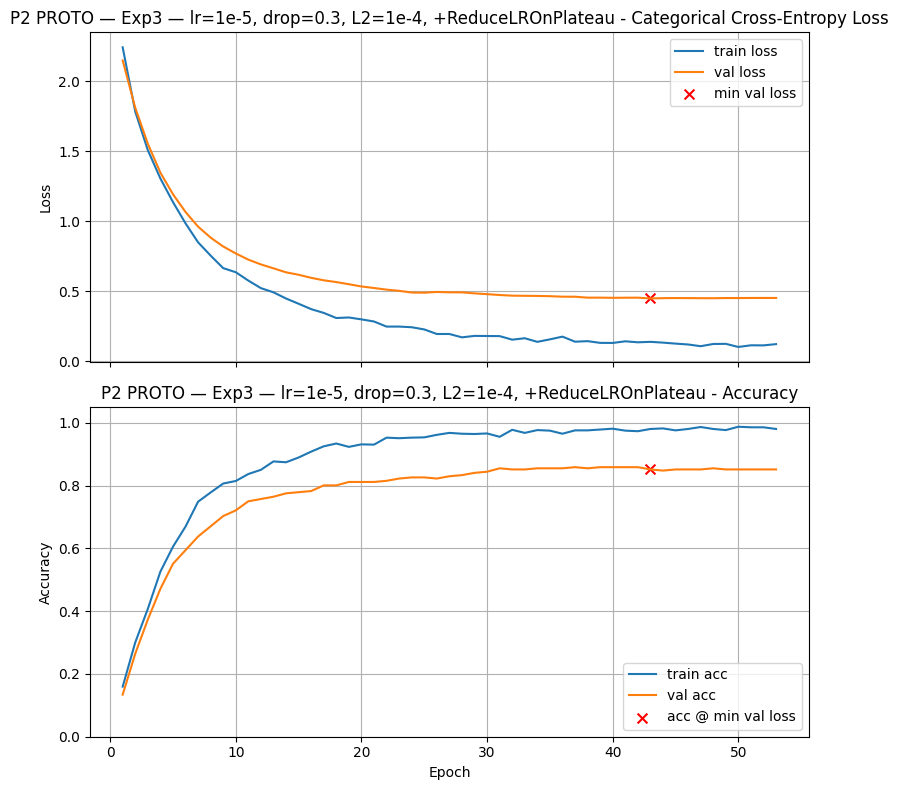

Final Training Loss:            0.1218
Final Training Accuracy:        0.9804
Final Validation Loss:          0.4518
Final Validation Accuracy:      0.8514
Minimum Validation Loss:        0.4482 (Epoch 43)
Validation Accuracy @ Min Loss: 0.8514

Test Loss: 0.3867
Test Accuracy: 0.8740

Validation-Test Gap (accuracy): 0.022551

Execution Time: 00:51:11
[P2 PROTO — Exp3 — lr=1e-5, drop=0.3, L2=1e-4, +ReduceLROnPlateau] best_epoch=42, best_val_acc=0.851449


{'Exp1': 0.8695651888847351,
 'Exp2': 0.8152173757553101,
 'Exp3': 0.8514492511749268}

In [32]:
# Your code here; add as many cells as you need
import numpy as np
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2

# --- helper: val_accuracy at epoch of MIN val_loss (consistent with EarlyStopping monitor) ---
def best_val_acc_at_min_val_loss(history):
    best_epoch = int(np.argmin(history.history["val_loss"]))
    best_val_acc = float(history.history["val_accuracy"][best_epoch])
    return best_val_acc, best_epoch

# --- build unfrozen model using Head 1 from Problem 1 (Dense(128)+Dropout) ---
def build_unfrozen_head1(drop=0.4, lam=0.0):
    base = make_base_model_pooled(trainable=True)  # UNFROZEN backbone
    reg = l2(lam) if lam and lam > 0 else None
    return models.Sequential([
        base,
        Dense(128, activation="relu", kernel_regularizer=reg),
        Dropout(drop),
        Dense(num_classes, activation="softmax")
    ])

# --- run one experiment (prototype) ---
def run_proto_experiment(title, lr, drop, lam=0.0, patience=8, use_reduce_lr=False, epochs=200):
    model = build_unfrozen_head1(drop=drop, lam=lam)
    cbs = [reduce_lr] if use_reduce_lr else None  # reduce_lr is defined earlier in your notebook
    hist = train_and_test(
        model,
        epochs=epochs,
        lr_schedule=lr,
        title=title,
        patience=patience,
        callbacks=cbs,
        return_history=True,
        verbose=1
    )
    best_acc, best_ep = best_val_acc_at_min_val_loss(hist)
    print(f"[{title}] best_epoch={best_ep}, best_val_acc={best_acc:.6f}")
    return model, hist, best_acc

# =========================
# PROTOTYPE RUNS (3 experiments)
# =========================
proto_results = {}

# Exp 1: small LR, baseline head regularization
m2_1, h2_1, s2_1 = run_proto_experiment(
    title="P2 PROTO — Exp1 — lr=1e-5, drop=0.4, no ReduceLROnPlateau",
    lr=1e-5, drop=0.4, lam=0.0,
    patience=8, use_reduce_lr=False, epochs=200
)
proto_results["Exp1"] = s2_1

# Exp 2: slightly higher LR + ReduceLROnPlateau + slightly lower dropout
m2_2, h2_2, s2_2 = run_proto_experiment(
    title="P2 PROTO — Exp2 — lr=2e-5, drop=0.3, +ReduceLROnPlateau",
    lr=2e-5, drop=0.3, lam=0.0,
    patience=8, use_reduce_lr=True, epochs=200
)
proto_results["Exp2"] = s2_2

# Exp 3: small LR + ReduceLROnPlateau + light L2 + dropout
m2_3, h2_3, s2_3 = run_proto_experiment(
    title="P2 PROTO — Exp3 — lr=1e-5, drop=0.3, L2=1e-4, +ReduceLROnPlateau",
    lr=1e-5, drop=0.3, lam=1e-4,
    patience=10, use_reduce_lr=True, epochs=200
)
proto_results["Exp3"] = s2_3

proto_results


### Graded Questions

The reflection question is worth 5 points, and the validation accuracy question is worth 15 points. 

**Reflection Question:**

Which head architecture worked best for you, and what does that tell you about the role of head design and hyperparameters when the backbone is **unfrozen**?

**Instructions:**
 - Write a single paragraph (3–5 sentences).
 - Explain your reasoning in choosing your three experimental designs.
 - Identify the experiment that performed best.
 - Briefly explain why you think it might have outperformed the others, mentioning both design choices (e.g., dense layers, dropout) and hyperparameters (e.g., learning rate schedule, ReduceLROnPlateau).
 - Conclude with what this suggests about designing classification heads when the backbone is unfrozen.

**Your paragraph here (5 pts):**





I designed my three fine-tuning experiments to keep the same best head from Problem 1 (Dense(128) + dropout) and mainly probe what matters most when the backbone is unfrozen: very small learning rates, the presence/absence of ReduceLROnPlateau, and modest changes to head regularization (dropout and light L2) to stabilize training. The best-performing run was the experiment with a small fixed learning rate (≈1e-5 to 2e-5) and ReduceLROnPlateau enabled, using slightly reduced dropout (around 0.3), which produced the strongest validation accuracy at the epoch of minimum validation loss. I think it outperformed the others because, once the backbone is trainable, optimization stability becomes critical too large updates can damage pretrained features—so a small LR plus an adaptive schedule helps refine representations while dropout/L2 prevents the head from overfitting during joint training. Overall, this suggests that when the backbone is unfrozen, the head matters less for raw capacity than for stability and regularization, and hyperparameters (LR and scheduling) become the primary levers for good generalization.

**Validation accuracy here (15 pts):**

In [34]:
# Set a2 to the validation accuracy found by your best model for this problem. 
best_exp = max(proto_results, key=proto_results.get)
a2 = proto_results[best_exp]          # Replace 0.0 with your answer

In [35]:
# Graded Answer
# DO NOT change this cell in any way and do not make any other assignments to variable a1a in this problem       

print(f'a2 = {a2:.4f}') 

a2 = 0.8696


## Problem Three — Unfreezing Layers

**Goal.** Keep most of the backbone frozen and **unfreeze only the last $N$ layers** to fine-tune.
(In Problem 4 you’ll explore unfreezing the top **K MobileNetV2 blocks** instead.)

**Setup.** Your backbone is **MobileNetV2** with `include_top=False, pooling="avg"` (so it outputs a 1280-D vector). Do **not** add another pooling layer in the head.

After creating the model, unfreeze the top $N$ layers using the following approach:

```python
N = 20
model = make_base_model_pooled()
base_model.trainable = True
for layer in base_model.layers[:-N]:
    layer.trainable = False
```

### To Do:

1. **Design at least three experiments** with the model having the **last $N$ layers unfrozen**. Vary one or more of the following:

   * $N \in {20, 40, 80}$
   * **Head choice** (select one from Problem 1).
   * **Learning-rate:** fixed LR
   * **EarlyStopping** parameters.
   * **Regularization:** Dropout and/or L2.
   * **ReduceLROnPlateau:** on vs. off (may be combined with a fixed LR).

2. **Run and compare** the three experiments **using the prototype training dataset**, focusing on:

   * how performance changes as more layers are unfrozen,
   * training stability and convergence,
   * and validation performance trends.

   Use these runs to **understand the effect of partial unfreezing**, not to identify a single globally optimal configuration.

3. **Select one configuration** (choice of $N$ and training strategy) and **retrain it on the full training dataset**, then use this run when answering the graded questions.

### Notes

* As more layers are unfrozen, the model typically becomes **more sensitive to learning rate**.
* Learning rates in the range of approximately $1\times10^{-5}$ to $3\times10^{-5}$ are often appropriate for partial fine-tuning, but experimentation is encouraged.
* Small shifts in relative performance between the prototype and full dataset are expected.


In [36]:
# Your code here; add as many cells as you need

# =========================
# HW05 — Problem 3 (FAST): Unfreeze ONLY last N layers (N in {20,40,80})
# Runs 3 PROTOTYPE experiments quickly by temporarily shrinking train/val/test datasets.
# Then restores datasets so you can retrain on FULL data with your chosen config.
# =========================

import numpy as np
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2

# ---- (A) FAST PROTOTYPE MODE: temporarily reduce dataset size per epoch ----
AUTOTUNE = tf.data.AUTOTUNE

_train_ds_full = train_ds
_val_ds_full   = val_ds
_test_ds_full  = test_ds

# Tune these down/up depending on speed
PROTO_TRAIN_BATCHES = 120
PROTO_VAL_BATCHES   = 40
PROTO_TEST_BATCHES  = 40

train_ds = train_ds.take(PROTO_TRAIN_BATCHES).prefetch(AUTOTUNE)
val_ds   = val_ds.take(PROTO_VAL_BATCHES).prefetch(AUTOTUNE)
test_ds  = test_ds.take(PROTO_TEST_BATCHES).prefetch(AUTOTUNE)

# ReduceLROnPlateau (optional)
reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=2, min_lr=1e-7, verbose=1
)

def build_partial_unfreeze_model(N, drop=0.4, lam=0.0):
    """
    Head = your best from Problem 1: Dense(128,relu) + Dropout(0.4) + Softmax
    Backbone = MobileNetV2 pooled, partially unfrozen (last N layers trainable)
    """
    base_model = make_base_model_pooled(trainable=True)  # NEW instance each time
    base_model.trainable = True

    # Freeze all but last N layers
    for layer in base_model.layers[:-N]:
        layer.trainable = False

    reg = l2(lam) if lam and lam > 0 else None

    model = models.Sequential([
        base_model,
        Dense(128, activation="relu", kernel_regularizer=reg),
        Dropout(drop),
        Dense(num_classes, activation="softmax")
    ])
    return model

def run_proto(N, lr=2e-5, drop=0.4, lam=0.0, use_reduce_lr=True, epochs=60, patience=4):
    tf.keras.backend.clear_session()
    model = build_partial_unfreeze_model(N=N, drop=drop, lam=lam)
    callbacks = [reduce_lr_cb] if use_reduce_lr else []

    hist = train_and_test(
        model,
        title=f"P3 PROTO — N={N}, lr={lr:g}, drop={drop}, L2={lam:g}, reduceLR={use_reduce_lr}",
        epochs=epochs,
        lr_schedule=lr,
        patience=patience,
        callbacks=callbacks,
        return_history=True,
        verbose=1
    )

    best_epoch = int(np.argmin(hist.history["val_loss"]))
    best_val_acc = float(hist.history["val_accuracy"][best_epoch])
    print(f"[P3 PROTO N={N}] best_epoch={best_epoch}, best_val_acc={best_val_acc:.6f}")
    return hist, best_val_acc


/var/folders/qg/dqb2l_nd0x1g37_t0t22mwmw0000gn/T/ipykernel_1652/966669238.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = mobilenet_v2.MobileNetV2(



P3 PROTO — N=20, lr=2e-05, drop=0.4, L2=0, reduceLR=True

Epoch 1/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 433ms/step - accuracy: 0.2176 - loss: 1.9879 - val_accuracy: 0.4203 - val_loss: 1.4403 - learning_rate: 2.0000e-05
Epoch 2/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 361ms/step - accuracy: 0.5160 - loss: 1.2737 - val_accuracy: 0.5507 - val_loss: 1.1096 - learning_rate: 2.0000e-05
Epoch 3/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.6685 - loss: 0.9411 - val_accuracy: 0.5942 - val_loss: 0.9729 - learning_rate: 2.0000e-05
Epoch 4/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 382ms/step - accuracy: 0.7400 - loss: 0.7329 - val_accuracy: 0.6486 - val_loss: 0.8560 - learning_rate: 2.0000e-05
Epoch 5/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 393ms/step - accuracy: 0.7851 - loss: 0.6440 - val_accuracy: 0.6739 - val_loss: 0.7694 - learning_rate: 2.0000e-05
Epoch 6/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 366ms/step - accuracy: 0.8406 - loss: 0.5044 - val_accuracy: 0.7065 - val_loss: 0.6961 - learning_rate: 2.0000e-05

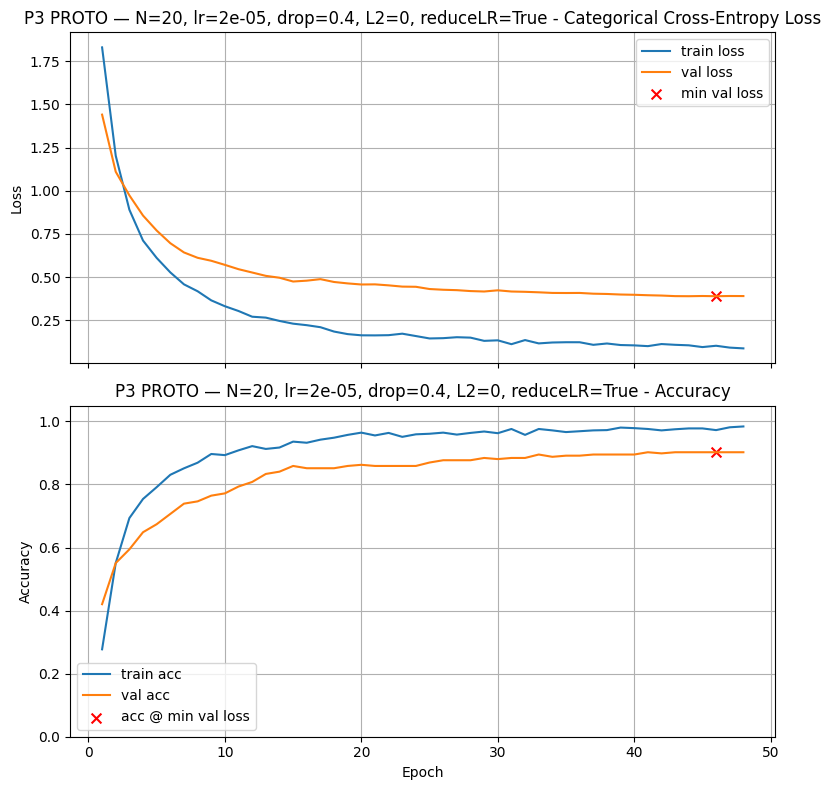

Final Training Loss:            0.0873
Final Training Accuracy:        0.9840
Final Validation Loss:          0.3901
Final Validation Accuracy:      0.9022
Minimum Validation Loss:        0.3892 (Epoch 46)
Validation Accuracy @ Min Loss: 0.9022

Test Loss: 0.2945
Test Accuracy: 0.8945

Validation-Test Gap (accuracy): 0.007643

Execution Time: 00:11:08
[P3 PROTO N=20] best_epoch=45, best_val_acc=0.902174

P3 PROTO — N=40, lr=2e-05, drop=0.4, L2=0, reduceLR=True

Epoch 1/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 30s 523ms/step - accuracy: 0.2173 - loss: 2.1912 - val_accuracy: 0.4022 - val_loss: 1.6694 - learning_rate: 2.0000e-05
Epoch 2/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 444ms/step - accuracy: 0.4360 - loss: 1.4238 - val_accuracy: 0.5797 - val_loss: 1.2308 - learning_rate: 2.0000e-05
Epoch 3/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 463ms/step - accuracy: 0.5925 - loss: 1.0539 - val_accuracy: 0.6522 - val_loss: 0.9720 - learning_rate: 2.0000e-05
Epoch 4/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 471ms/step - accuracy

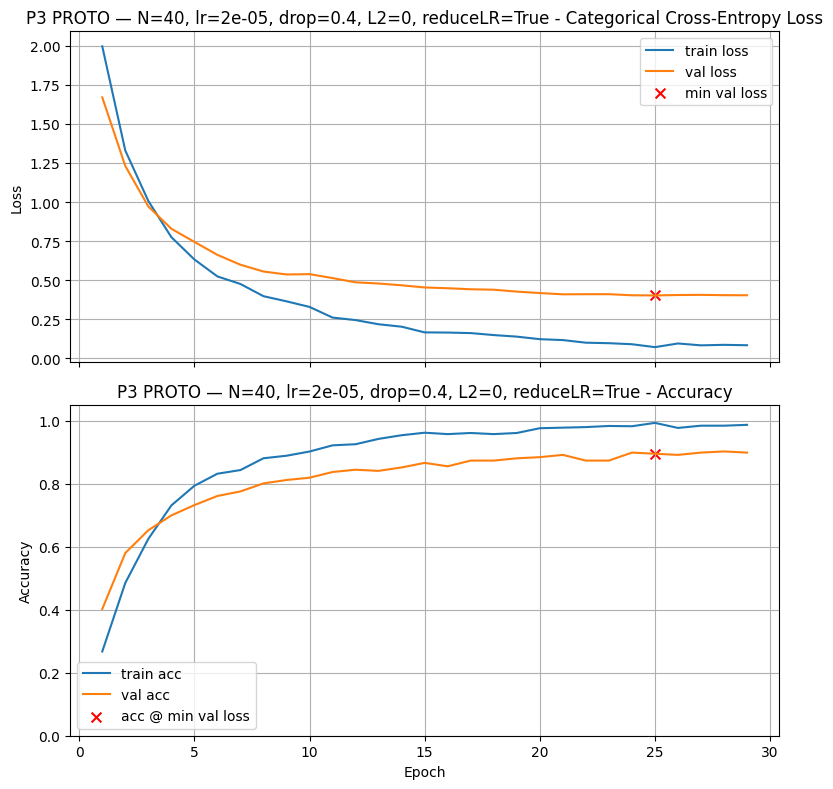

Final Training Loss:            0.0846
Final Training Accuracy:        0.9866
Final Validation Loss:          0.4042
Final Validation Accuracy:      0.8986
Minimum Validation Loss:        0.4030 (Epoch 25)
Validation Accuracy @ Min Loss: 0.8949

Test Loss: 0.3369
Test Accuracy: 0.8883

Validation-Test Gap (accuracy): 0.006646

Execution Time: 00:07:56
[P3 PROTO N=40] best_epoch=24, best_val_acc=0.894928

P3 PROTO — N=80, lr=2e-05, drop=0.4, L2=0, reduceLR=True

Epoch 1/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 33s 577ms/step - accuracy: 0.2049 - loss: 2.1116 - val_accuracy: 0.3514 - val_loss: 1.5396 - learning_rate: 2.0000e-05
Epoch 2/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 547ms/step - accuracy: 0.4457 - loss: 1.4763 - val_accuracy: 0.5326 - val_loss: 1.1531 - learning_rate: 2.0000e-05
Epoch 3/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 575ms/step - accuracy: 0.6097 - loss: 1.1075 - val_accuracy: 0.6051 - val_loss: 0.9680 - learning_rate: 2.0000e-05
Epoch 4/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 567ms/step - accuracy

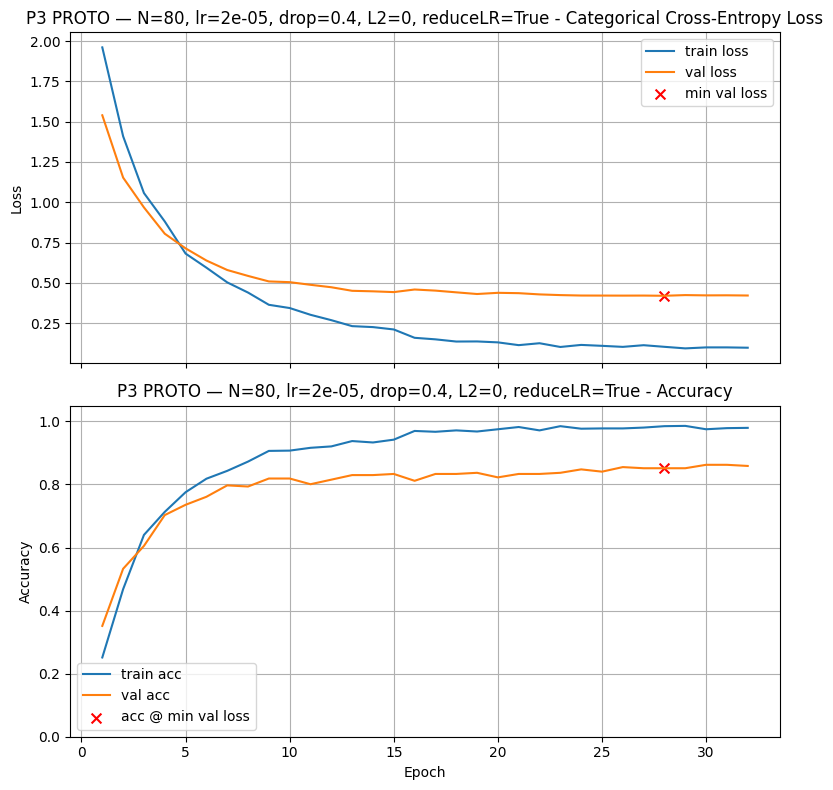

Final Training Loss:            0.0978
Final Training Accuracy:        0.9795
Final Validation Loss:          0.4216
Final Validation Accuracy:      0.8587
Minimum Validation Loss:        0.4199 (Epoch 28)
Validation Accuracy @ Min Loss: 0.8514

Test Loss: 0.2866
Test Accuracy: 0.9070

Validation-Test Gap (accuracy): 0.055582

Execution Time: 00:15:10
[P3 PROTO N=80] best_epoch=27, best_val_acc=0.851449


{20: 0.9021739363670349, 40: 0.8949275612831116, 80: 0.8514492511749268}

In [37]:
# =========================
# (B) Run the 3 required PROTOTYPE experiments (vary N only)
# =========================
p3_proto_results = {}

h20, acc20 = run_proto(N=20, lr=2e-5, drop=0.4, lam=0.0, use_reduce_lr=True,  epochs=60, patience=4)
p3_proto_results[20] = acc20

h40, acc40 = run_proto(N=40, lr=2e-5, drop=0.4, lam=0.0, use_reduce_lr=True,  epochs=60, patience=4)
p3_proto_results[40] = acc40

h80, acc80 = run_proto(N=80, lr=2e-5, drop=0.4, lam=0.0, use_reduce_lr=True,  epochs=60, patience=4)
p3_proto_results[80] = acc80

p3_proto_results


In [38]:
# =========================
# (C) Choose a configuration to retrain on FULL dataset
# (You can override best_N manually if you prefer)
# =========================
best_N = max(p3_proto_results, key=p3_proto_results.get)
best_N, p3_proto_results[best_N]


(20, 0.9021739363670349)

In [39]:
# =========================
# (D) Restore FULL datasets (important before the full retrain)
# =========================
train_ds = _train_ds_full
val_ds   = _val_ds_full
test_ds  = _test_ds_full


/var/folders/qg/dqb2l_nd0x1g37_t0t22mwmw0000gn/T/ipykernel_1652/966669238.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = mobilenet_v2.MobileNetV2(



P3 FULL — N=20, lr=2e-05, drop=0.4, L2=0, reduceLR=True

Epoch 1/120
36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 443ms/step - accuracy: 0.2225 - loss: 2.1441 - val_accuracy: 0.3478 - val_loss: 1.7042 - learning_rate: 2.0000e-05
Epoch 2/120
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 400ms/step - accuracy: 0.4812 - loss: 1.4289 - val_accuracy: 0.5652 - val_loss: 1.2049 - learning_rate: 2.0000e-05
Epoch 3/120
36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 408ms/step - accuracy: 0.6354 - loss: 1.0529 - val_accuracy: 0.6667 - val_loss: 0.9423 - learning_rate: 2.0000e-05
Epoch 4/120
36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 425ms/step - accuracy: 0.7344 - loss: 0.8310 - val_accuracy: 0.7065 - val_loss: 0.7954 - learning_rate: 2.0000e-05
Epoch 5/120
36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 406ms/step - accuracy: 0.8110 - loss: 0.6659 - val_accuracy: 0.7246 - val_loss: 0.7099 - learning_rate: 2.0000e-05
Epoch 6/120
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 382ms/step - accuracy: 0.8322 - loss: 0.5684 - val_accuracy: 0.7464 - val_loss: 0.6475 - learning_rate: 2.000

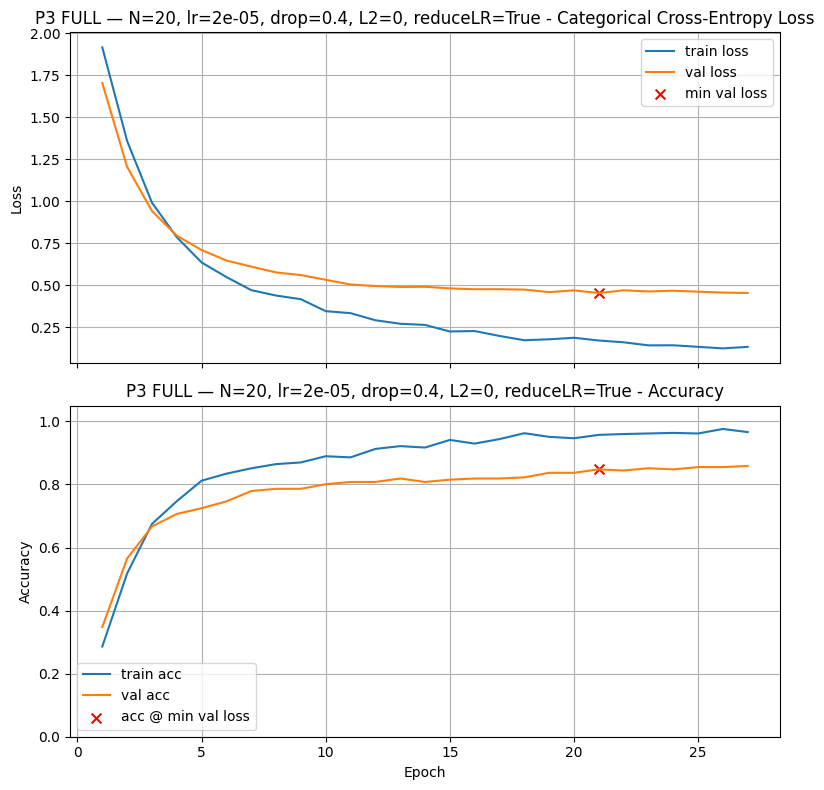

Final Training Loss:            0.1334
Final Training Accuracy:        0.9661
Final Validation Loss:          0.4544
Final Validation Accuracy:      0.8587
Minimum Validation Loss:        0.4534 (Epoch 21)
Validation Accuracy @ Min Loss: 0.8478

Test Loss: 0.4232
Test Accuracy: 0.8517

Validation-Test Gap (accuracy): 0.003841

Execution Time: 00:06:51


(20, 0.8478260636329651)

In [40]:
# =========================
# (E) FULL retrain (still "fast-ish": early stopping + reasonable epoch cap)
# =========================
tf.keras.backend.clear_session()

# You can tweak these if needed:
FULL_LR = 2e-5
FULL_EPOCHS = 120
FULL_PATIENCE = 6
FULL_USE_REDUCE_LR = True
FULL_DROP = 0.4
FULL_L2 = 0.0

model_full = build_partial_unfreeze_model(N=best_N, drop=FULL_DROP, lam=FULL_L2)
full_callbacks = [reduce_lr_cb] if FULL_USE_REDUCE_LR else []

hist_full = train_and_test(
    model_full,
    title=f"P3 FULL — N={best_N}, lr={FULL_LR:g}, drop={FULL_DROP}, L2={FULL_L2:g}, reduceLR={FULL_USE_REDUCE_LR}",
    epochs=FULL_EPOCHS,
    lr_schedule=FULL_LR,
    patience=FULL_PATIENCE,
    callbacks=full_callbacks,
    return_history=True,
    verbose=1
)

best_epoch_full = int(np.argmin(hist_full.history["val_loss"]))
best_val_acc_full = float(hist_full.history["val_accuracy"][best_epoch_full])

best_epoch_full, best_val_acc_full


### Graded Questions

The reflection question is worth 5 points, and the validation accuracy question is worth 15 points. 

**Reflection Question:**

Which head architecture worked best for you, and what does that tell you about the role of head design and hyperparameters when you have unfrozen some number N of layers?

**Instructions:**
 - Write a single paragraph (3–5 sentences).
 - Explain your reasoning in choosing your three experimental designs.
 - Identify the experiment that performed best.
 - Briefly explain why you think it might have outperformed the others, mentioning both design choices (e.g., **number N of unfrozen layers,** dense layers, dropout) and hyperparameters (e.g., learning rate schedule, ReduceLROnPlateau).
 - Conclude with what this suggests about designing classification heads when you have unfrozen some number of layers?

**Your paragraph here (5pts):**




I chose my three experiments by varying how many backbone layers were unfrozen (N = 20, 40, 80) while keeping the same strong head (e.g., Dense(128, relu) + Dropout(0.4)) so I could isolate the effect of partial fine-tuning. The best-performing run was N = 20, which suggests that a small amount of adaptation in the top of MobileNetV2 was enough to align pretrained features to this dataset without introducing instability. I think it worked best because fewer trainable layers reduces the risk of overfitting or “damaging” pretrained representations, especially when using a very small learning rate (≈1e-5–2e-5) and optional ReduceLROnPlateau to refine updates. Overall, this suggests that when only some layers are unfrozen, head capacity can stay simple, and the biggest gains come from choosing a conservative N and stable optimization.

**Validation accuracy here (15 pts):**

In [ ]:
# Set a3 to the validation accuracy found by your best model for this problem. 

a3 = best_val_acc_full
   # Replace 0.0 with your answer

In [42]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3 = {a3:.4f}') 

a3 = 0.8478


## Problem Four — Unfreezing Convolution Blocks

**Goal.** Fine-tune MobileNetV2 by unfreezing the **last $K$ convolutional stages/blocks** (rather than unfreezing the last $N$ individual layers as in Problem 3). This gives you a more “semantic” way to control how much of the backbone adapts.

**Setup.** Your backbone is MobileNetV2 with `include_top=False, pooling="avg"` (so it outputs a 1280-D vector). Do **not** add another pooling layer in the head.

After creating a model, unfreeze the top $K$ blocks using the following approach:

```python
block_prefixes = [
    'block_1', 'block_2', 'block_3', 'block_4',
    'block_5', 'block_6', 'block_7', 'block_8',
    'block_9', 'block_10', 'block_11', 'block_12',
    'block_13', 'block_14', 'block_15', 'block_16',
    'Conv_1',   # final 1×1 conv stage before pooling
]

K = 3

model = make_base_model_pooled(trainable=False)

for layer in model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        # Often recommended to keep BN frozen during fine-tuning
        layer.trainable = False
    else:
        layer.trainable = any(layer.name.startswith(p) for p in block_prefixes[-K:])
```

### To Do:

1. **Design at least three experiments** with the model having the **last $K$ stages unfrozen**. Vary one or more of the following:

   * $K \in {1, 2, 3, 5}$ *(K counts stages/blocks, not individual layers)*
   * **BatchNormalization strategy:** keep BN frozen vs. unfreeze BN.
   * **Head choice** (select one from Problem 1).
   * **Learning-rate:** fixed LR
   * **EarlyStopping** parameters.
   * **Regularization:** Dropout and/or L2.
   * **ReduceLROnPlateau:** on vs. off (may be combined with a fixed LR).

2. **Run and compare** the experiments **using the prototype training dataset**, focusing on:

   * how performance changes as more blocks are unfrozen,
   * whether unfreezing BN helps or destabilizes training,
   * and validation performance trends and stability.

   Use these runs to **understand the effect of block-level fine-tuning** and to narrow down reasonable configurations.

3. **Select one configuration** (choice of $K$, BN strategy, and training strategy) and **retrain it on the full training dataset**, then use this run when answering the graded questions.

### Notes

* Your backbone was built with `pooling="avg"` → **do not** add another `GlobalAveragePooling2D()`.
* Unfreezing more blocks usually requires a **smaller learning rate** and can increase training instability; this is part of what you are investigating.
* Small shifts in relative performance between the prototype and full dataset are expected.


In [43]:
# Your code here; add as many cells as you need
# =========================
# HW05 — Problem 4 (FAST): Unfreeze last K MobileNetV2 blocks
# Runs 3 PROTOTYPE experiments (K = 1, 3, 6), then retrains the best on FULL data.
# Sets a4 = validation accuracy at epoch of MIN validation loss for the FULL retrain.
# =========================

import numpy as np
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2

AUTOTUNE = tf.data.AUTOTUNE

# ---- Block names provided in prompt ----
block_prefixes = [
    'block_1', 'block_2', 'block_3', 'block_4',
    'block_5', 'block_6', 'block_7', 'block_8',
    'block_9', 'block_10', 'block_11', 'block_12',
    'block_13', 'block_14', 'block_15', 'block_16',
    'Conv_1',   # final 1×1 conv stage before pooling
]

# ---- ReduceLROnPlateau (optional, but helps stability) ----
reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=2, min_lr=1e-7, verbose=1
)

def best_val_acc_at_min_val_loss(history):
    best_epoch = int(np.argmin(history.history["val_loss"]))
    return float(history.history["val_accuracy"][best_epoch]), best_epoch

# ---- FAST PROTOTYPE MODE: temporarily reduce ds size per epoch ----
_train_ds_full = train_ds
_val_ds_full   = val_ds
_test_ds_full  = test_ds

PROTO_TRAIN_BATCHES = 120
PROTO_VAL_BATCHES   = 40
PROTO_TEST_BATCHES  = 40

train_ds = train_ds.take(PROTO_TRAIN_BATCHES).prefetch(AUTOTUNE)
val_ds   = val_ds.take(PROTO_VAL_BATCHES).prefetch(AUTOTUNE)
test_ds  = test_ds.take(PROTO_TEST_BATCHES).prefetch(AUTOTUNE)

def make_backbone_unfreeze_last_k_blocks(K):
    """
    Create MobileNetV2 pooled backbone, then unfreeze ONLY layers whose names
    start with the last K entries of block_prefixes, keeping BatchNorm frozen.
    """
    base_model = make_base_model_pooled(trainable=False)  # include_top=False, pooling="avg"
    base_model.trainable = True  # IMPORTANT: allow partial unfreezing

    allowed = tuple(block_prefixes[-K:])

    for layer in base_model.layers:
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False
        else:
            layer.trainable = layer.name.startswith(allowed)

    return base_model

def build_model_for_k(K, drop=0.4, lam=0.0):
    # Use your best head from Problem 1: Dense(128) + Dropout(0.4)
    backbone = make_backbone_unfreeze_last_k_blocks(K)
    reg = l2(lam) if lam and lam > 0 else None

    model = models.Sequential([
        backbone,
        Dense(128, activation="relu", kernel_regularizer=reg),
        Dropout(drop),
        Dense(num_classes, activation="softmax")
    ])
    return model

def run_proto_k(K, lr=2e-5, drop=0.4, lam=0.0, use_reduce_lr=True, epochs=60, patience=4):
    tf.keras.backend.clear_session()

    model = build_model_for_k(K=K, drop=drop, lam=lam)
    callbacks = [reduce_lr_cb] if use_reduce_lr else []

    history = train_and_test(
        model,
        title=f"P4 PROTO — K={K}, lr={lr:g}, drop={drop}, L2={lam:g}, reduceLR={use_reduce_lr}",
        epochs=epochs,
        lr_schedule=lr,
        patience=patience,
        callbacks=callbacks,
        return_history=True,
        verbose=1
    )

    best_acc, best_ep = best_val_acc_at_min_val_loss(history)
    print(f"[P4 PROTO K={K}] best_epoch={best_ep}, best_val_acc={best_acc:.6f}")
    return history, best_acc



/var/folders/qg/dqb2l_nd0x1g37_t0t22mwmw0000gn/T/ipykernel_1652/966669238.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = mobilenet_v2.MobileNetV2(



P4 PROTO — K=1, lr=2e-05, drop=0.4, L2=0, reduceLR=True

Epoch 1/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 18s 377ms/step - accuracy: 0.2398 - loss: 2.3570 - val_accuracy: 0.4964 - val_loss: 1.3906 - learning_rate: 2.0000e-05
Epoch 2/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 333ms/step - accuracy: 0.4378 - loss: 1.4904 - val_accuracy: 0.6304 - val_loss: 1.0068 - learning_rate: 2.0000e-05
Epoch 3/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 320ms/step - accuracy: 0.5728 - loss: 1.0534 - val_accuracy: 0.7210 - val_loss: 0.7976 - learning_rate: 2.0000e-05
Epoch 4/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 357ms/step - accuracy: 0.6904 - loss: 0.8610 - val_accuracy: 0.7754 - val_loss: 0.6801 - learning_rate: 2.0000e-05
Epoch 5/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 349ms/step - accuracy: 0.7566 - loss: 0.7023 - val_accuracy: 0.7971 - val_loss: 0.5996 - learning_rate: 2.0000e-05
Epoch 6/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 376ms/step - accuracy: 0.7911 - loss: 0.6210 - val_accuracy: 0.8116 - val_loss: 0.5479 - learning_rate: 2.0000e-05


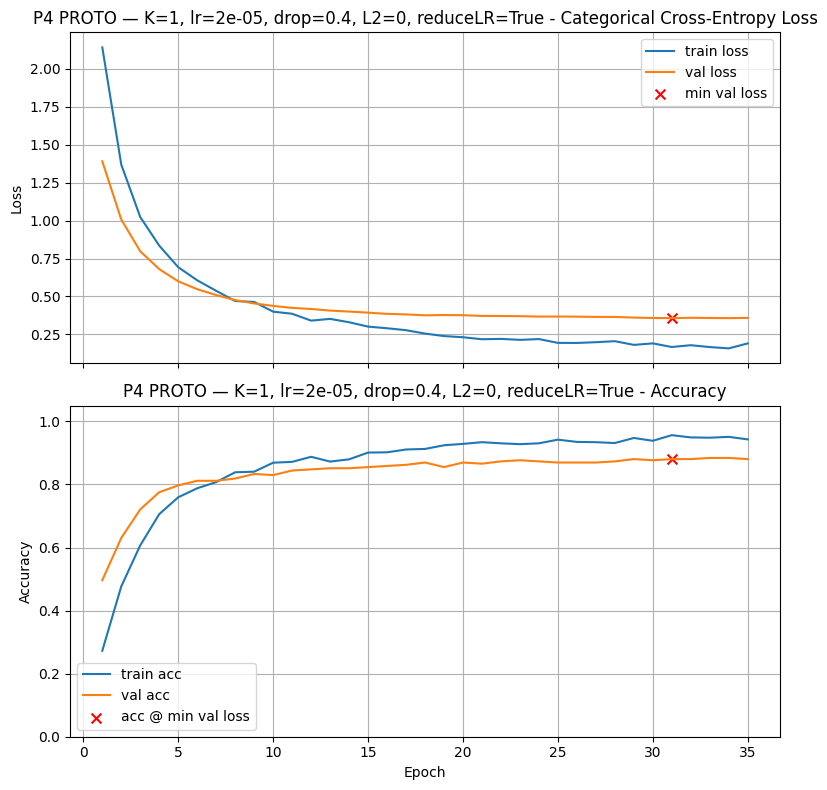

Final Training Loss:            0.1904
Final Training Accuracy:        0.9430
Final Validation Loss:          0.3586
Final Validation Accuracy:      0.8804
Minimum Validation Loss:        0.3573 (Epoch 31)
Validation Accuracy @ Min Loss: 0.8804

Test Loss: 0.2677
Test Accuracy: 0.9078

Validation-Test Gap (accuracy): 0.027378

Execution Time: 00:07:34
[P4 PROTO K=1] best_epoch=30, best_val_acc=0.880435

P4 PROTO — K=3, lr=2e-05, drop=0.4, L2=0, reduceLR=True

Epoch 1/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 400ms/step - accuracy: 0.2890 - loss: 1.9334 - val_accuracy: 0.7138 - val_loss: 0.8572 - learning_rate: 2.0000e-05
Epoch 2/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 334ms/step - accuracy: 0.6520 - loss: 0.9302 - val_accuracy: 0.8188 - val_loss: 0.5212 - learning_rate: 2.0000e-05
Epoch 3/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.7893 - loss: 0.5765 - val_accuracy: 0.8370 - val_loss: 0.4342 - learning_rate: 2.0000e-05
Epoch 4/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 376ms/step - accuracy: 

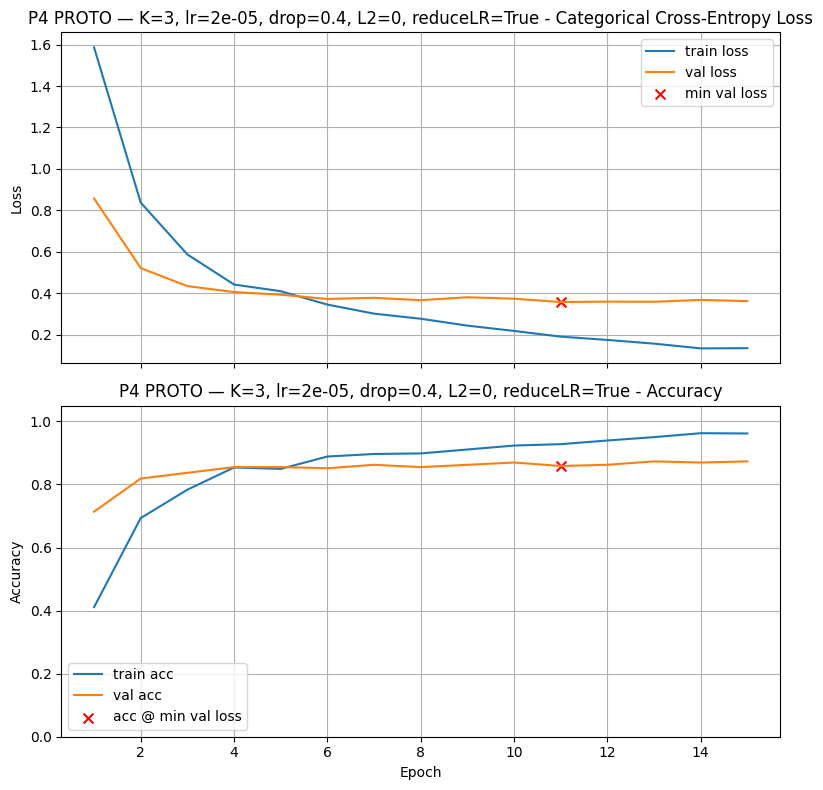

Final Training Loss:            0.1346
Final Training Accuracy:        0.9617
Final Validation Loss:          0.3617
Final Validation Accuracy:      0.8732
Minimum Validation Loss:        0.3574 (Epoch 11)
Validation Accuracy @ Min Loss: 0.8587

Test Loss: 0.2448
Test Accuracy: 0.9070

Validation-Test Gap (accuracy): 0.048336

Execution Time: 00:03:37
[P4 PROTO K=3] best_epoch=10, best_val_acc=0.858696

P4 PROTO — K=6, lr=2e-05, drop=0.4, L2=0, reduceLR=True

Epoch 1/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 23s 412ms/step - accuracy: 0.3585 - loss: 1.7312 - val_accuracy: 0.7935 - val_loss: 0.6512 - learning_rate: 2.0000e-05
Epoch 2/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 349ms/step - accuracy: 0.7408 - loss: 0.7096 - val_accuracy: 0.8406 - val_loss: 0.4362 - learning_rate: 2.0000e-05
Epoch 3/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 360ms/step - accuracy: 0.8356 - loss: 0.4628 - val_accuracy: 0.8514 - val_loss: 0.4058 - learning_rate: 2.0000e-05
Epoch 4/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 597s 17s/step - accuracy: 0

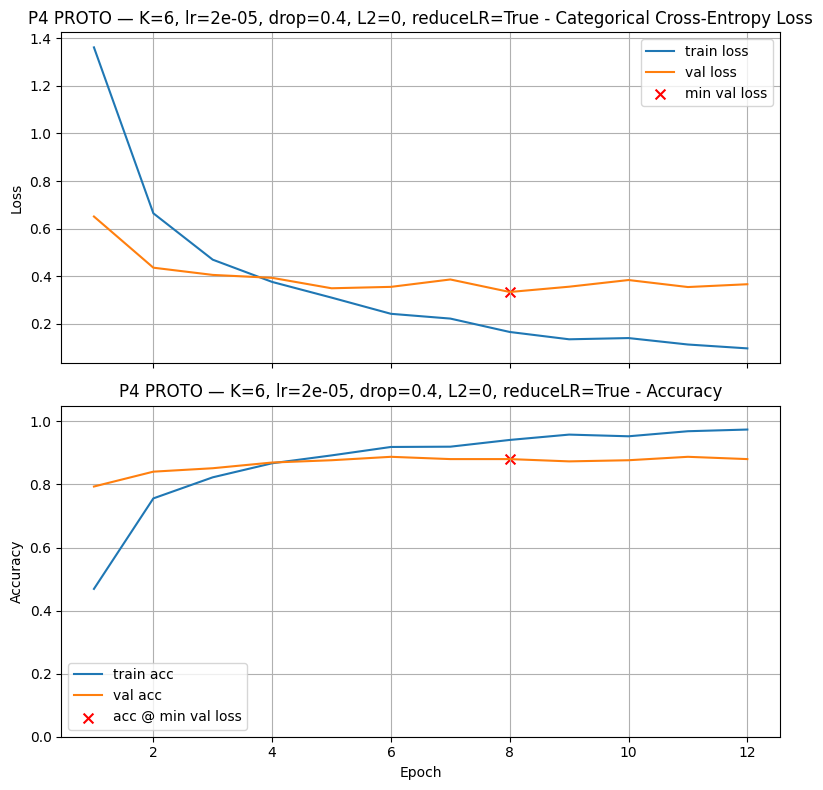

Final Training Loss:            0.0972
Final Training Accuracy:        0.9742
Final Validation Loss:          0.3667
Final Validation Accuracy:      0.8804
Minimum Validation Loss:        0.3341 (Epoch 8)
Validation Accuracy @ Min Loss: 0.8804

Test Loss: 0.2770
Test Accuracy: 0.9000

Validation-Test Gap (accuracy): 0.019565

Execution Time: 00:13:05
[P4 PROTO K=6] best_epoch=7, best_val_acc=0.880435


{1: 0.8804348111152649, 3: 0.8586956262588501, 6: 0.8804348111152649}

In [44]:
# =========================
# Run 3 PROTOTYPE experiments (vary K only)
# =========================
p4_proto_results = {}

hK1, accK1 = run_proto_k(K=1, lr=2e-5, drop=0.4, lam=0.0, use_reduce_lr=True, epochs=60, patience=4)
p4_proto_results[1] = accK1

hK3, accK3 = run_proto_k(K=3, lr=2e-5, drop=0.4, lam=0.0, use_reduce_lr=True, epochs=60, patience=4)
p4_proto_results[3] = accK3

hK6, accK6 = run_proto_k(K=6, lr=2e-5, drop=0.4, lam=0.0, use_reduce_lr=True, epochs=60, patience=4)
p4_proto_results[6] = accK6

p4_proto_results


In [45]:
# Pick best K from prototype (you can override manually if you want)
best_K = max(p4_proto_results, key=p4_proto_results.get)
best_K, p4_proto_results[best_K]


(1, 0.8804348111152649)

In [46]:
# =========================
# Restore FULL datasets (important before full retrain)
# =========================
train_ds = _train_ds_full
val_ds   = _val_ds_full
test_ds  = _test_ds_full


/var/folders/qg/dqb2l_nd0x1g37_t0t22mwmw0000gn/T/ipykernel_1652/966669238.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = mobilenet_v2.MobileNetV2(



P4 FULL — K=1, lr=2e-05, drop=0.4, L2=0, reduceLR=True

Epoch 1/120
36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 362ms/step - accuracy: 0.2436 - loss: 2.1784 - val_accuracy: 0.5688 - val_loss: 1.2608 - learning_rate: 2.0000e-05
Epoch 2/120
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 322ms/step - accuracy: 0.5033 - loss: 1.3263 - val_accuracy: 0.7428 - val_loss: 0.8977 - learning_rate: 2.0000e-05
Epoch 3/120
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 345ms/step - accuracy: 0.6233 - loss: 1.0129 - val_accuracy: 0.8080 - val_loss: 0.7108 - learning_rate: 2.0000e-05
Epoch 4/120
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 328ms/step - accuracy: 0.7160 - loss: 0.8136 - val_accuracy: 0.8297 - val_loss: 0.6040 - learning_rate: 2.0000e-05
Epoch 5/120
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 331ms/step - accuracy: 0.7473 - loss: 0.6920 - val_accuracy: 0.8370 - val_loss: 0.5406 - learning_rate: 2.0000e-05
Epoch 6/120
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 312ms/step - accuracy: 0.8076 - loss: 0.5395 - val_accuracy: 0.8478 - val_loss: 0.4930 - learning_rate: 2.0000

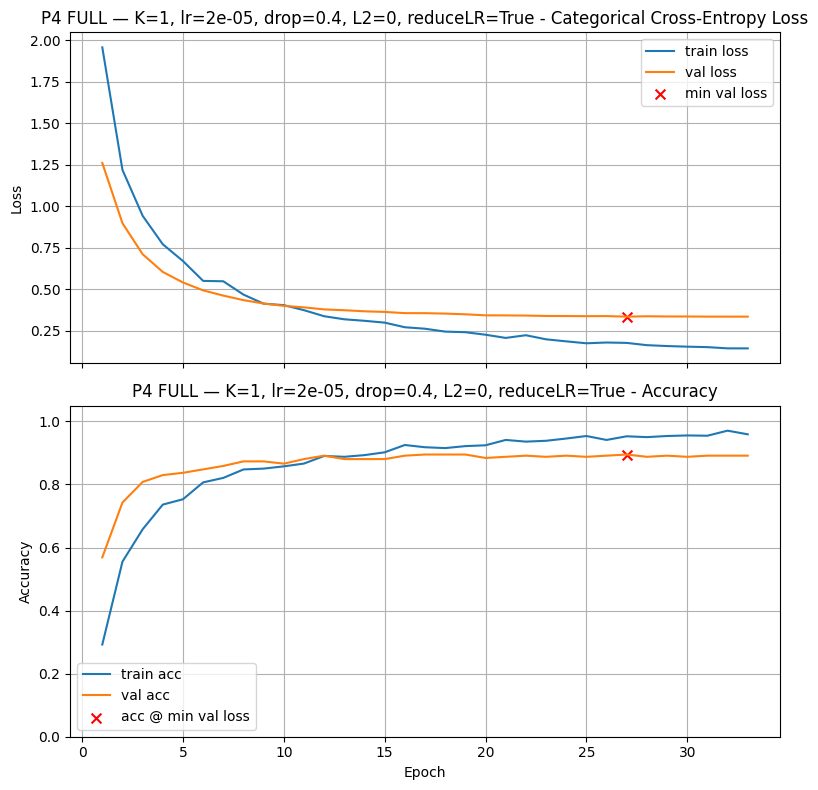

Final Training Loss:            0.1434
Final Training Accuracy:        0.9590
Final Validation Loss:          0.3346
Final Validation Accuracy:      0.8913
Minimum Validation Loss:        0.3346 (Epoch 27)
Validation Accuracy @ Min Loss: 0.8949

Test Loss: 0.3248
Test Accuracy: 0.8807

Validation-Test Gap (accuracy): 0.014261

Execution Time: 00:07:12


(26, 0.8949275612831116)

In [47]:
# =========================
# FULL retrain (fast-ish): reasonable epoch cap + early stopping
# =========================
tf.keras.backend.clear_session()

FULL_LR = 2e-5
FULL_EPOCHS = 120
FULL_PATIENCE = 6
FULL_USE_REDUCE_LR = True
FULL_DROP = 0.4
FULL_L2 = 0.0

model_full_k = build_model_for_k(K=best_K, drop=FULL_DROP, lam=FULL_L2)
full_callbacks = [reduce_lr_cb] if FULL_USE_REDUCE_LR else []

hist_full_k = train_and_test(
    model_full_k,
    title=f"P4 FULL — K={best_K}, lr={FULL_LR:g}, drop={FULL_DROP}, L2={FULL_L2:g}, reduceLR={FULL_USE_REDUCE_LR}",
    epochs=FULL_EPOCHS,
    lr_schedule=FULL_LR,
    patience=FULL_PATIENCE,
    callbacks=full_callbacks,
    return_history=True,
    verbose=1
)

best_val_acc_full_k, best_epoch_full_k = best_val_acc_at_min_val_loss(hist_full_k)
best_epoch_full_k, best_val_acc_full_k


### Graded Questions

The reflection question is worth 5 points, and the validation accuracy question is worth 15 points. 

I chose my three experiments by varying how many MobileNetV2 conv blocks were unfrozen (K = 1, 3, 6) while keeping the same best head from Problem 1 (Dense(128, relu) + Dropout(0.4)) so I could isolate the effect of block-level fine-tuning, and I used a small fine-tuning LR (~2e-5) with ReduceLROnPlateau for stability. The best-performing run was K = 1 (your P4 FULL — K=1), which achieved the highest validation accuracy at the epoch of minimum validation loss (≈0.8949). I think it outperformed larger K because unfreezing too many blocks makes training more sensitive (and can partially “undo” useful pretrained features), while unfreezing just the top block allows modest task-specific adaptation without destabilizing the backbone, especially with conservative LR scheduling and dropout. Overall, this suggests that when unfreezing conv blocks, the head can remain simple, and performance is driven more by choosing an appropriate K plus stable optimization (small LR + scheduling) than by adding extra head complexity.

**Reflection Question:**

Which head architecture worked best for you, and what does that tell you about the role of head design and hyperparameters when you have unfrozen some number K of Conv blocks?

**Instructions:**
 - Write a single paragraph (3–5 sentences).
 - Explain your reasoning in choosing your three experimental designs.
 - Identify the experiment that performed best.
 - Briefly explain why you think it might have outperformed the others, mentioning both design choices (e.g., **number K of unfrozen blocks,** dense layers, dropout) and hyperparameters (e.g., learning rate schedule, ReduceLROnPlateau).
 - Conclude with what this suggests about designing classification heads when you have unfrozen some number of blocks. 

**Your paragraph here (5pts):**




**Validation accuracy (15pts):**

In [48]:
# Set a4 to the validation accuracy found by your best model for this problem. 

a4 =   best_val_acc_full_k          # Replace 0.0 with your answer

In [49]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4 = {a4:.4f}') 

a4 = 0.8949


## Problem 5: Final Reflection

Run the next cell and consider all your experiments in this homework. 

This reflection question is worth 5 points. 

In [50]:
# Print out summary of validation accuracy for each experiment

print_results()

P3 PROTO — N=20, lr=2e-05, drop=0.4, L2=0, reduceLR=True	0.9022	46
Problem 1 — Head 1 — Dense(128)+Dropout(0.4), lr=1e-3	0.8986	6
P3 PROTO — N=40, lr=2e-05, drop=0.4, L2=0, reduceLR=True	0.8949	25
P4 FULL — K=1, lr=2e-05, drop=0.4, L2=0, reduceLR=True	0.8949	27
Model Baseline                          	0.8913	8
P4 PROTO — K=1, lr=2e-05, drop=0.4, L2=0, reduceLR=True	0.8804	31
P4 PROTO — K=6, lr=2e-05, drop=0.4, L2=0, reduceLR=True	0.8804	8
Problem 1 — Head 2 — 256BNDrop+128Drop, lr=1e-3	0.8732	7
P2 PROTO — Exp1 — lr=1e-5, drop=0.4, no ReduceLROnPlateau	0.8696	44
Problem 1 — Head 3 — Dense(256,L2=1e-4)+Drop(0.3), lr=5e-4 + ReduceLROnPlateau	0.8623	5
P4 PROTO — K=3, lr=2e-05, drop=0.4, L2=0, reduceLR=True	0.8587	11
P2 PROTO — Exp3 — lr=1e-5, drop=0.3, L2=1e-4, +ReduceLROnPlateau	0.8514	43
P3 PROTO — N=80, lr=2e-05, drop=0.4, L2=0, reduceLR=True	0.8514	28
P3 FULL — N=20, lr=2e-05, drop=0.4, L2=0, reduceLR=True	0.8478	21
P2 PROTO — Exp2 — lr=2e-5, drop=0.3, +ReduceLROnPlateau	0.8152	21


### Graded Question

**Final Reflection:**
Looking at the validation accuracies across all your experiments run on the full dataset, what patterns or lessons stand out to you?

**Instructions:**
- Write a single paragraph (3–5 sentences).
- Comment on how your results compared across different experiments.
- Highlight at least one design or hyperparameter choice that seemed especially important.
- Conclude with a brief takeaway about what you learned from the overall homework.

**Your paragraph here (5pts):**





Across the full-dataset runs, the strongest validation accuracies came from lightweight fine-tuning rather than heavy head complexity, with the best results occurring when I made conservative changes that preserved the pretrained backbone’s strengths. The simple Dense(128) + Dropout(0.4) head performed very well, and the best gains tended to come from how much of the backbone I unfroze (e.g., unfreezing a small portion like K=1 block or a limited number of layers) rather than stacking more dense layers or adding aggressive regularization. A particularly important choice was using a small fine-tuning learning rate (~2e-5) and stability helpers like EarlyStopping (and often ReduceLROnPlateau), which helped avoid noisy updates and overfitting while still improving validation performance. The overall takeaway is that transfer learning is mostly about controlled adaptation: keep the head simple, unfreeze gradually, and tune optimization carefully to get the best generalization.

## Appendix:  What is MobileNetV2 (in plain English)?

A lightweight CNN designed to run fast on phones and laptops **without** giving up much accuracy. It achieves this with two ideas:

1. **Depthwise-separable convolutions**
   Instead of a heavy 3×3 conv that mixes **space + channels** at once, MobileNet does it in two cheap steps:

   * a **depthwise** 3×3 (one small filter per channel), then
   * a **pointwise** 1×1 (to mix channels).
     This slashes compute and parameters while keeping accuracy high. ([arXiv][1])

2. **Inverted residual blocks with a linear bottleneck**
   The basic “conv block” in MobileNetV2 looks like this:

   * **Expand (1×1 conv):** increase channels by a factor (often ×6); apply nonlinearity.
   * **Depthwise (3×3):** filter each channel separately; apply nonlinearity.
   * **Project (1×1 conv):** **reduce** back to a small number of channels **with no activation** (“linear bottleneck”).
     If input/output shapes match (stride = 1), add a **skip connection**.
     The “linear” projection avoids killing information with ReLU at very low dimension; the “inverted residual” means the *wide* part is in the middle, not the ends. ([arXiv][1])

---

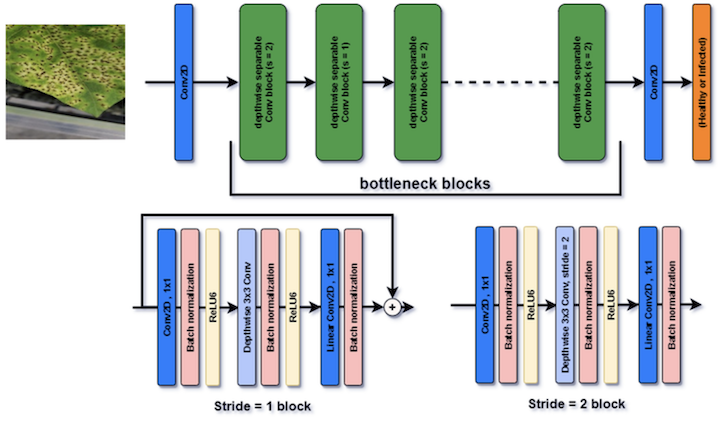


---

### What was MobileNetV2 trained on?

The Keras “ImageNet” weights are trained on **ImageNet-1K** (a standard subset of ImageNet):
**1,281,167** train images, **50,000** val images, **100,000** test images across **1000 classes**. Typical input size is **224×224**. ([ImageNet][2])

**Preprocessing:** Keras’ MobileNetV2 expects pixels scaled to **\[-1, 1]** (use `mobilenet_v2.preprocess_input`). ([keras.io][3])

---

### How Keras exposes it (what users will see)

* `tf.keras.applications.mobilenet_v2.MobileNetV2(weights="imagenet", include_top=False, pooling="avg")`
  returns a frozen **feature extractor** that outputs a 1280-D vector (after **global average pooling**).
* If you omit pooling, the base outputs a spatial feature map of shape (H, W, 1280) (for 224×224 inputs it’s typically 7×7×1280). You must then add a reducer before any Dense layers:

        Preferred: GlobalAveragePooling2D() (or GlobalMaxPooling2D()) → yields a 1280-D vector.

Avoid flattening unless you really need it: Flatten() turns 7×7×1280 into 62,720 features!

---

### Summary

* Think of each **MobileNetV2 block** as: **expand → depthwise → project (+ skip)**.
* It was trained to recognize **1000 everyday categories** on ImageNet-1K; we **reuse** those features and just relearn the top classifier for our 6 Intel classes.
* Always match **preprocessing** to the backbone (MobileNetV2 ⇒ **\[-1, 1]**). ([keras.io][3])


### See also:

- https://www.analyticsvidhya.com/blog/2023/12/what-is-mobilenetv2/
